MIT License

Copyright (c) 2022 John Shahla

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
# Import libraries 

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import torch

import torch.nn as nn

import torch.nn.functional as nnf

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

# SVM for multi-class classification using one-vs-rest
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold

# K-Fold Validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# Global Constants

# '../Models/OSR.model'
# '../Data/X-IIoTID dataset.csv'

MODEL_PATH_JOB = './ModelJob/OSR.model'
PATH_CSV = '../Data/X-IIoTID dataset.csv'
RESULT_PATH  = '../Results'
NROWS = 100000

In [14]:
# Read and clean X-IIoTID Dataset

class DatasetHandler():
    
    def __init__(self):

        self.data = pd.read_csv(PATH_CSV)

        # Encode categorical columns
        self.data = pd.get_dummies(self.data, columns=['Protocol', 'Service'])
        
        # Defining target class
        self.y = self.data['class2']
        


        self.data = self.data.drop(['Date', 'Timestamp', 'Scr_IP', 'Des_IP', 'class1', 'class2', 'class3'], axis=1)
        
        # Defining non-numbers values
        self.data = self.data.replace({False: 0, 'FALSE': 0, 'false': 0, True: 1, 'TRUE': 1, 'true': 1, '-': np.nan, '?': np.nan, '' : np.nan, ' ' : np.nan}).replace({'[A-Za-z]': np.nan}, regex=True)
        
        # Delete all columns that has 30%+ of NaN values in all their records
        for col in self.data.columns:
            count = self.data[col].isna().sum()
            
            if count/NROWS * 100 > 30.0:
                self.data = self.data.drop(col, axis=1)
                print('column deleted',col)
        
        # Remove any record that has NaN in it's features and resetting index for data
        to_del = []
        for col in self.data.columns:
            to_del.append(self.data[self.data[col].isin([np.nan])].index.tolist())

        to_del =  [j for sub in to_del for j in sub]

        self.data = self.data.drop(to_del, axis=0)
        self.data = self.data.reset_index()
        self.X_data= self.data
        self.y = self.y.drop(to_del, axis=0)
        self.encoded_labels = self.y.unique()

        
        # Encode target class with LabelEncoder
        self.le = LabelEncoder()
        self.y_data = self.le.fit_transform(self.y)
        
        # Convert all features into float32 for the neural network
        self.X_data = self.X_data.astype('float32')     
 #       print('D1', self.X_data.shape)
        # Convert training subset-dataset and deleted subset-dataset into ndarray
        self.X_data = self.X_data.values
   #     print('D2', self.X_data.shape)
        # Scaling features to unit variance
        self.scaler = MinMaxScaler()
        self.X_data = self.scaler.fit_transform(self.X_data)
    #    print('D3', self.X_data.shape)
        self.X_stored = self.X_data
        self.y_stored = self.y_data

        
    # Splitting our dataset into training and testing datasets
    def get_imbalanced_splits(self, class_to_del, min_num_rec):
        
        self.imbalancedSamplesX = []
        self.imbalancedSamplesY = []    
        
        self.X_data = self.X_stored
        self.y_data= self.y_stored
        
        # Remove the class_to_del class from class2 from training dataset in order to test it vs OSR model
        to_del2 = np.where(self.y_stored == class_to_del)[0]
        to_del3 = [i for i in to_del2]

        self.x_deleted = self.X_stored[to_del3]        
        self.X_data = np.delete(self.X_data,to_del3,axis = 0)

        self.y_data = np.delete(self.y_data,to_del3,axis = 0)

        self.x_deleted = self.scaler.fit_transform(self.x_deleted)
        for i in range(len(np.unique(self.y_stored))):
            self.s = np.where(self.y_data==i)[0]

            if len(self.s) > min_num_rec : 
                
                self.imbalancedSamplesX.extend(self.X_data[self.s[:]])
                self.imbalancedSamplesY.extend(self.y_data[self.s[:]])
                
            continue
        
        self.imbalancedSamplesX = np.array(self.imbalancedSamplesX)
        self.imbalancedSamplesY = np.array(self.imbalancedSamplesY)
        if len(self.imbalancedSamplesY) == 0 :
            return -1,-1,-1,-1,-1
        
        self.imbalancedSamplesY = self.le.fit_transform(self.imbalancedSamplesY)
        
        self.bxtrain , self.bxtest , self.bytrain, self.bytest = train_test_split(self.imbalancedSamplesX,self.imbalancedSamplesY, test_size=0.2, random_state=3)
        return  self.bxtrain , self.bxtest , self.bytrain, self.bytest, self.x_deleted
    
    def get_balanced_splits(self, class_to_del, min_num_rec, max_num_rec): 
        
        self.balancedSamplesX = []
        self.balancedSamplesY = []    
        
        self.X_data = self.X_stored
        self.y_data= self.y_stored
        
        # Remove the class_to_del class from class2 from training dataset in order to test it vs OSR model
        to_del2 = np.where(self.y_stored == class_to_del)[0]
        to_del3 = [i for i in to_del2]

        self.x_deleted = self.X_stored[to_del3]        
        self.X_data = np.delete(self.X_data,to_del3,axis = 0)
        self.y_data = np.delete(self.y_data,to_del3,axis = 0)
        self.x_deleted = self.scaler.fit_transform(self.x_deleted)
        for i in range(len(np.unique(self.y_stored))):
            self.s = np.where(self.y_data==i)[0]

            if len(self.s) > min_num_rec :

                try : 
                    
                    self.balancedSamplesX.extend(self.X_data[self.s[:max_num_rec]])
                    self.balancedSamplesY.extend(self.y_data[self.s[:max_num_rec]])
                except : 
                    self.balancedSamplesX.extend(self.X_data[self.s])
                    self.balancedSamplesY.extend(self.y_data[self.s])
                continue 
        
        
        


        
        self.balancedSamplesX = np.array(self.balancedSamplesX)
        self.balancedSamplesY = np.array(self.balancedSamplesY)
        if len(self.balancedSamplesY) == 0 :
            return -1,-1,-1,-1,-1
        
        self.balancedSamplesY = self.le.fit_transform(self.balancedSamplesY)
        
        self.bxtrain , self.bxtest , self.bytrain, self.bytest = train_test_split(self.balancedSamplesX,self.balancedSamplesY, test_size=0.2, random_state=3)
        return  self.bxtrain , self.bxtest , self.bytrain, self.bytest, self.x_deleted
        
        
    #get number of lables 
    def get_num_labels(self):
        return len(np.unique(self.y_data))

    #get number of featuers 
    def get_num_features(self):
            return self.X_data.shape[1]

In [4]:
#training data loader
class OsrTrainDataLoader():
    def __init__(self,X_train,y_train):
        self.x_data = torch.from_numpy(X_train)
        self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_train)
        self.y_data.type(torch.FloatTensor)
        self.len = X_train.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

#testing data loader 
class OsrTestDataLoader():
    def __init__(self,X_test,y_test):
        self.x_data = torch.from_numpy(X_test)
        self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_test)
        self.y_data.type(torch.FloatTensor)
        self.len = X_test.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [5]:
# Define deep neural network model 
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        #define layer 1 
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        #define layer 2 
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #input for first layer 
        out = self.layer1(x)
        out = self.sigmoid(out)
        #input for second layer 
        out = self.layer2(out)
        return out

# Define a model 


In [6]:
# Predict a row and get max class-probability and the class 
def predict(row, model):
    
    # Convert row to data
    row = torch.FloatTensor([row])
    
    # Make prediction
    yhat = model(row)
    
    # Retrieve numpy array
    prob = nnf.softmax(yhat, dim=1)
    top_p, top_class = torch.tensor(prob).topk(1, dim = 1)
    
    return top_p, top_class

In [7]:
# Calculate the best theshold for the unknown classes 
# Error rate is True Unknown predictions + False Known predictions 
# Modfiy true_negative and false_negative for bigger emphasis on error rate 
# i.g for bigger emphasis on true_negative accuracy (True unkown predictions) use : true_negative  * 2 

def get_threshold (X_data, x_deleted, range_thresh, model):
    
    lowest_error = 0 
    best_thresh = 0 
    min_error = 100
    
    # Change the len for more accurate reults
    # The bigger range the more accurate results 
    deleted_len = 500 if x_deleted.shape[0]>500 else x_deleted.shape[0]
    
    
    # Plotting true_negative (true unknown classes) and false_negative (false known classes) with thresholds 
    thresh_li = []
    true_negative_li = []
    false_negative_li = []
    error_list = [] 
    acc_list = []
    pred_del = []
    pred_test = [] 
    
    for record_idx in range(deleted_len):
        pred_del.append(predict(x_deleted[record_idx],model)[0].tolist()[0][0])
        pred_test.append(predict(X_data[record_idx],model)[0].tolist()[0][0])
    pred_deleted = np.array(pred_del)
    pred_tested = np.array(pred_test)

    for thresh in [th/1000 for th in range(range_thresh[0],range_thresh[1])]:
        error_combined  = 0 
        true_negative = 0 
        false_negative  = 0 
        thresh_li.append(thresh)
        true_negative = sum(pred_deleted < thresh)
        false_negative = sum(pred_tested < thresh)
        true_negative_li.append(100 -true_negative/deleted_len*100)
        false_negative_li.append(false_negative/deleted_len*100)
        error_combined = (100 - true_negative/deleted_len*100 + false_negative/deleted_len*100 )/2
        error_list.append(error_combined)
        if error_combined < min_error :
            min_error = error_combined
            best_thresh = thresh 
            lowest_error  = min_error
            acc_list = [true_negative/deleted_len*100, false_negative/deleted_len*100]

    return lowest_error/100, best_thresh, acc_list, thresh_li, true_negative_li, false_negative_li, error_list

In [8]:
def draw_thresh_plots(thresh_li , true_negative_li, false_negative_li , error_list,path):
    plt.plot(thresh_li,false_negative_li, label = 'False Negative (False Known Predictions)')
    plt.plot(thresh_li,true_negative_li ,label = 'True Negative (True Unknown Predictions)')
    plt.plot(thresh_li, error_list , label = 'Error rate (For Both Knowns and Unknowns)' )
    plt.xlabel('Threshold')
    plt.ylabel('Percentage')
    plt.title('Thresh/Error rate')
    plt.savefig(path)
    plt.show()

In [9]:
def predict_all(row, model, thresh):
    prob, top_class  = predict(row, model)
    if prob.tolist()[0][0] < thresh :
        print("Unkown Class")
    else : 
        print(df.encoded_labels[top_class.tolist()[0][0]-1])

In [26]:
def mlp_train(class_to_del,num_of_classes,X,x,Y,y,dell,PATHH):

    
    batch_size = 50


# Number of hidden dimensions 
    hidden_dim = 32


    data_set = OsrTrainDataLoader(X,Y)
    train_loader = DataLoader(
        batch_size=batch_size,
        dataset = data_set,
        shuffle=True
    )

    # Initialize training training loader 
    test_data_set = OsrTestDataLoader(x,y)
    test_loader = DataLoader(
        batch_size=1,
        dataset = test_data_set,
        shuffle=False
    )
    model = Model(X.shape[1], hidden_dim, num_of_classes)

    # Define loss functions 
    loss_func = nn.CrossEntropyLoss()

    # Define optimizer 
    optimizer = torch.optim.SGD(model.parameters(), lr=2)

    # Define number of epochs to train
    epochs = 1


    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = Variable(inputs.type(torch.FloatTensor))
            labels = Variable(labels.type(torch.FloatTensor))
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.type(torch.LongTensor))
            loss.backward()
            optimizer.step()

            if(i+1) % 100 == 0:
                total = 0
                correct = 0
                for ins, l in test_loader:
                    ins = Variable(ins.type(torch.FloatTensor))
                    outs = model(ins)
                    _, predicted = torch.max(outs.data, 1)

                    total = total+ l.size(0)
                    equal = predicted.type(torch.IntTensor) == l.type(torch.IntTensor)
                    if int(equal) == 1:
                        correct= correct + 1

                accuracy = 100 * correct/total
                print("iteration ", i+1, " in Epoch ", epoch, " Loss : ", loss.data, " Accuracy: ", accuracy)
    lowest_error, best_thresh, acc_list, thresh_li, true_negative_li, false_negative_li, error_list = get_threshold(x, dell, [100,999], model)
    draw_thresh_plots(thresh_li , true_negative_li, false_negative_li, error_list,PATHH)
    
    
    y_predd = []
    for i in x :
        y_predd.append(predict(i,model)[1][0][0].tolist())
    
    classification = metrics.classification_report(list(y), y_predd)

    # Define K-Fold 10
    
    # Report performance
    res =  classification 
    res = res + " \n Lowest error " + str(lowest_error) 
    res = res + '\n best Thresh ' + str(best_thresh)
    print(res)
    with open('{}.txt'.format(PATHH), 'w') as f:
        f.write(str(res))

        
    return lowest_error

In [11]:
def MLP_balanced_experiment(min_rec,max_rec,PATHH):
    df = DatasetHandler()
    err_li = []
    trained_loops = 0 
    for i in range(10):
        path = PATHH + df.encoded_labels[i] + '/'+ df.encoded_labels[i] 
        X,x,Y,y,dell = df.get_balanced_splits(i,min_rec,max_rec)
        if(type(X) == int):
            continue
        num_of_classes = len(np.unique(Y))
        err_li.append(mlp_train(i,num_of_classes,X,x,Y,y,dell,path))
        trained_loops = trained_loops + 1 
 
    with open('{}ERROR RATE.txt'.format(PATHH), 'w') as f:
        f.write(str(sum(err_li)/trained_loops))

In [12]:
def create_MLP_experiment_balanced(path):
    for i in [500,1000,2500,5000,10000]:
        PATHH = path + '{}'.format(i) + '/'
        MLP_balanced_experiment(0.6*i,i,PATHH)

/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


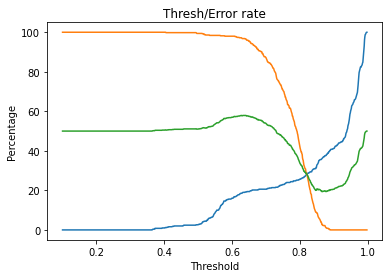

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       109
           1       0.86      0.91      0.89        94
           2       0.96      0.71      0.82       112
           3       0.88      0.91      0.89        86
           4       0.91      1.00      0.95        94
           5       0.91      0.59      0.72       105
           6       0.78      1.00      0.88        92
           7       0.84      1.00      0.92       108
           8       0.95      1.00      0.98        61

    accuracy                           0.89       861
   macro avg       0.90      0.90      0.89       861
weighted avg       0.90      0.89      0.89       861
 
 Lowest error 0.19399999999999998
 best Thresh 0.865


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


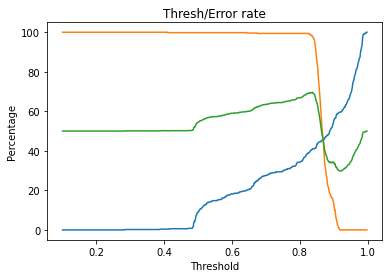

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       109
           1       0.98      0.85      0.91        94
           2       0.71      0.90      0.80       112
           3       0.82      0.87      0.84        86
           4       0.99      1.00      0.99        94
           5       0.89      0.70      0.79       105
           6       0.91      0.65      0.76        92
           7       0.84      1.00      0.92       108
           8       0.95      1.00      0.98        61

    accuracy                           0.88       861
   macro avg       0.89      0.88      0.88       861
weighted avg       0.89      0.88      0.88       861
 
 Lowest error 0.298
 best Thresh 0.919


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


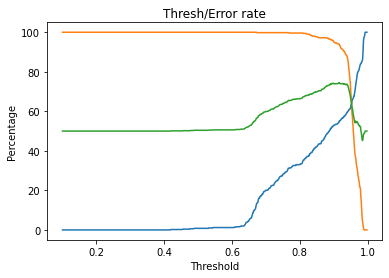

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       109
           1       0.99      0.99      0.99        94
           2       0.95      0.75      0.84       112
           3       0.87      0.91      0.89        86
           4       1.00      1.00      1.00        94
           5       0.94      0.75      0.84       105
           6       0.80      1.00      0.89        92
           7       0.85      0.98      0.91       108
           8       0.95      1.00      0.98        61

    accuracy                           0.92       861
   macro avg       0.92      0.93      0.92       861
weighted avg       0.92      0.92      0.92       861
 
 Lowest error 0.452
 best Thresh 0.985


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


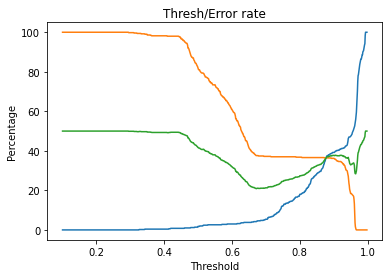

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       109
           1       0.99      0.99      0.99        94
           2       0.61      0.88      0.72       112
           3       0.68      0.92      0.78        86
           4       1.00      1.00      1.00        94
           5       0.71      0.05      0.09       105
           6       1.00      1.00      1.00        92
           7       0.85      0.99      0.91       108
           8       1.00      1.00      1.00        61

    accuracy                           0.85       861
   macro avg       0.87      0.86      0.83       861
weighted avg       0.86      0.85      0.81       861
 
 Lowest error 0.20900000000000002
 best Thresh 0.671


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


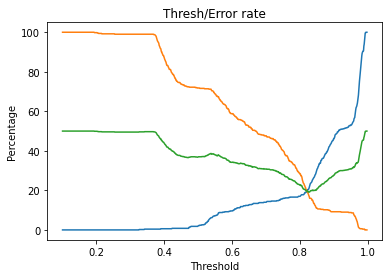

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       109
           1       1.00      0.99      0.99        94
           2       0.91      0.83      0.87       112
           3       0.86      0.76      0.80        86
           4       1.00      1.00      1.00        94
           5       0.87      0.70      0.77       105
           6       0.84      1.00      0.91        92
           7       0.81      1.00      0.89       108
           8       0.98      1.00      0.99        61

    accuracy                           0.91       861
   macro avg       0.92      0.92      0.91       861
weighted avg       0.92      0.91      0.91       861
 
 Lowest error 0.191
 best Thresh 0.826


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


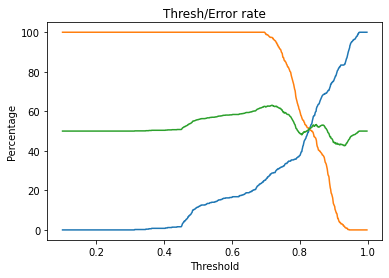

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       109
           1       1.00      0.99      0.99        94
           2       0.95      0.62      0.75       112
           3       0.95      0.73      0.83        86
           4       0.65      0.96      0.77        94
           5       0.64      0.83      0.72       105
           6       0.84      1.00      0.91        92
           7       0.90      0.84      0.87       108
           8       0.98      1.00      0.99        61

    accuracy                           0.84       861
   macro avg       0.88      0.86      0.85       861
weighted avg       0.87      0.84      0.84       861
 
 Lowest error 0.426
 best Thresh 0.933


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


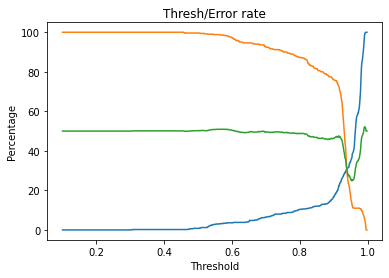

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       109
           1       0.99      0.99      0.99        94
           2       0.98      0.88      0.93       112
           3       0.95      0.67      0.79        86
           4       0.81      0.83      0.82        94
           5       0.94      1.00      0.97       105
           6       0.79      1.00      0.88        92
           7       1.00      0.99      1.00       108
           8       0.98      1.00      0.99        61

    accuracy                           0.93       861
   macro avg       0.93      0.92      0.92       861
weighted avg       0.93      0.93      0.92       861
 
 Lowest error 0.24799999999999997
 best Thresh 0.954


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


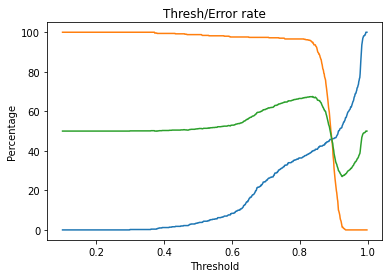

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       109
           1       0.99      0.99      0.99        94
           2       0.98      0.75      0.85       112
           3       0.89      0.98      0.93        86
           4       0.76      0.86      0.81        94
           5       0.98      1.00      0.99       105
           6       0.79      0.71      0.75        92
           7       0.90      0.99      0.94       108
           8       1.00      1.00      1.00        61

    accuracy                           0.91       861
   macro avg       0.91      0.91      0.91       861
weighted avg       0.91      0.91      0.91       861
 
 Lowest error 0.27
 best Thresh 0.925


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


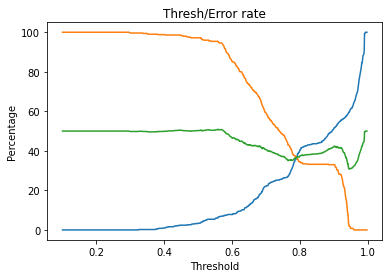

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       109
           1       1.00      0.99      0.99        94
           2       0.96      0.80      0.87       112
           3       0.88      0.77      0.82        86
           4       0.78      0.80      0.79        94
           5       0.97      1.00      0.99       105
           6       0.85      0.89      0.87        92
           7       0.86      1.00      0.92       108
           8       1.00      1.00      1.00        61

    accuracy                           0.91       861
   macro avg       0.91      0.91      0.91       861
weighted avg       0.91      0.91      0.91       861
 
 Lowest error 0.30699999999999994
 best Thresh 0.946


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


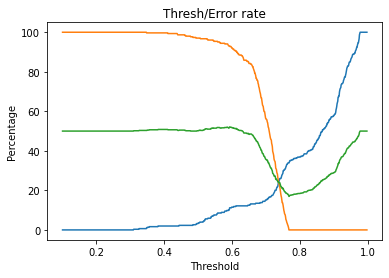

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       107
           1       0.96      0.99      0.97        93
           2       0.93      0.70      0.80       100
           3       0.98      0.62      0.76        80
           4       0.80      0.89      0.84       111
           5       1.00      1.00      1.00        96
           6       0.70      0.78      0.74       102
           7       0.88      1.00      0.94       117
           8       0.90      0.95      0.92        94

    accuracy                           0.89       900
   macro avg       0.90      0.88      0.88       900
weighted avg       0.89      0.89      0.88       900
 
 Lowest error 0.16940789473684212
 best Thresh 0.768


/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(0.4661)  Accuracy:  85.4375
iteration  100  in Epoch  1  Loss :  tensor(0.4107)  Accuracy:  88.1875
iteration  100  in Epoch  2  Loss :  tensor(0.1179)  Accuracy:  93.8125


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


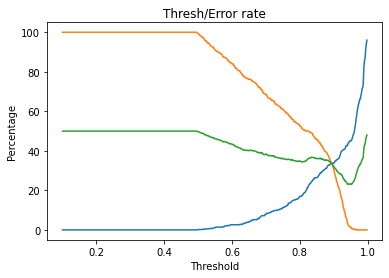

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       195
           1       0.96      0.92      0.94       215
           2       0.98      0.81      0.89       188
           3       0.89      0.94      0.91       191
           4       1.00      1.00      1.00       204
           5       0.85      0.80      0.83       204
           6       0.87      1.00      0.93       199
           7       0.93      0.98      0.95       204

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600
 
 Lowest error 0.23099999999999998
 best Thresh 0.953
iteration  100  in Epoch  0  Loss :  tensor(0.4699)  Accuracy:  82.875
iteration  100  in Epoch  1  Loss :  tensor(0.2033)  Accuracy:  91.6875
iteration  100  in Epoch  2  Loss :  tensor(0.2977)  Accuracy:  90.375


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


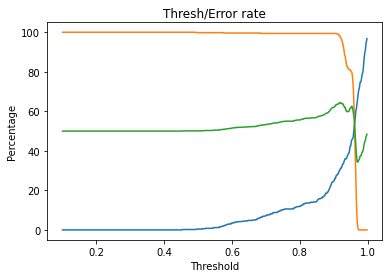

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       195
           1       0.99      0.90      0.94       215
           2       0.98      0.81      0.89       188
           3       0.86      0.94      0.90       191
           4       1.00      1.00      1.00       204
           5       0.87      0.80      0.83       204
           6       0.87      1.00      0.93       199
           7       0.92      0.98      0.95       204

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.92      1600
weighted avg       0.93      0.93      0.92      1600
 
 Lowest error 0.342
 best Thresh 0.971
iteration  100  in Epoch  0  Loss :  tensor(0.5307)  Accuracy:  86.0625
iteration  100  in Epoch  1  Loss :  tensor(0.2347)  Accuracy:  90.3125
iteration  100  in Epoch  2  Loss :  tensor(0.5080)  Accuracy:  93.9375


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


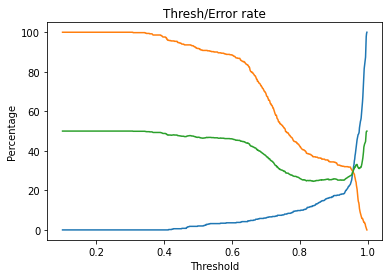

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       195
           1       1.00      1.00      1.00       215
           2       0.99      0.80      0.88       188
           3       0.86      0.94      0.90       191
           4       1.00      1.00      1.00       204
           5       0.99      0.75      0.85       204
           6       0.85      1.00      0.92       199
           7       0.88      1.00      0.94       204

    accuracy                           0.93      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.94      0.93      0.93      1600
 
 Lowest error 0.24600000000000002
 best Thresh 0.839
iteration  100  in Epoch  0  Loss :  tensor(0.4473)  Accuracy:  87.125
iteration  100  in Epoch  1  Loss :  tensor(0.1361)  Accuracy:  95.375
iteration  100  in Epoch  2  Loss :  tensor(0.3919)  Accuracy:  95.5625


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


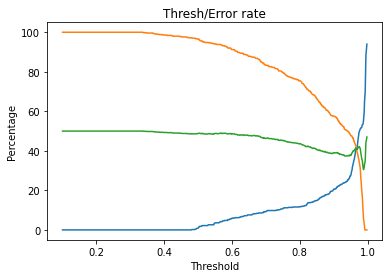

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       195
           1       1.00      1.00      1.00       215
           2       1.00      0.96      0.98       188
           3       0.92      0.70      0.79       191
           4       1.00      1.00      1.00       204
           5       0.75      0.84      0.79       204
           6       1.00      1.00      1.00       199
           7       0.91      0.99      0.95       204

    accuracy                           0.94      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.94      0.94      0.93      1600
 
 Lowest error 0.30500000000000005
 best Thresh 0.988
iteration  100  in Epoch  0  Loss :  tensor(0.4228)  Accuracy:  83.625
iteration  100  in Epoch  1  Loss :  tensor(0.3119)  Accuracy:  92.8125
iteration  100  in Epoch  2  Loss :  tensor(0.0319)  Accuracy:  95.3125


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


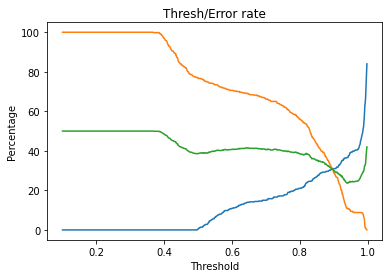

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       195
           1       1.00      1.00      1.00       215
           2       0.97      0.98      0.98       188
           3       0.73      0.97      0.83       191
           4       1.00      1.00      1.00       204
           5       0.97      0.85      0.91       204
           6       0.99      0.68      0.81       199
           7       0.91      1.00      0.95       204

    accuracy                           0.93      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.95      0.93      0.93      1600
 
 Lowest error 0.236
 best Thresh 0.942
iteration  100  in Epoch  0  Loss :  tensor(0.6094)  Accuracy:  81.5625
iteration  100  in Epoch  1  Loss :  tensor(0.4907)  Accuracy:  88.75
iteration  100  in Epoch  2  Loss :  tensor(0.3255)  Accuracy:  92.5625


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


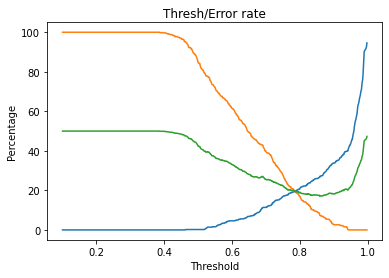

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       195
           1       1.00      1.00      1.00       215
           2       0.97      0.98      0.98       188
           3       0.98      0.80      0.88       191
           4       0.70      0.98      0.82       204
           5       0.99      0.75      0.85       204
           6       0.85      1.00      0.92       199
           7       0.91      1.00      0.95       204

    accuracy                           0.91      1600
   macro avg       0.92      0.90      0.90      1600
weighted avg       0.92      0.91      0.90      1600
 
 Lowest error 0.16999999999999996
 best Thresh 0.859
iteration  100  in Epoch  0  Loss :  tensor(0.4179)  Accuracy:  89.25
iteration  100  in Epoch  1  Loss :  tensor(0.3200)  Accuracy:  95.5625
iteration  100  in Epoch  2  Loss :  tensor(0.1178)  Accuracy:  95.9375


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


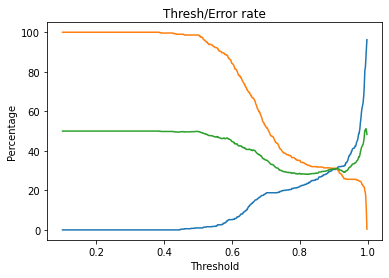

              precision    recall  f1-score   support

           0       0.99      0.68      0.80       195
           1       1.00      1.00      1.00       215
           2       0.98      0.99      0.99       188
           3       0.97      0.81      0.88       191
           4       0.75      0.96      0.84       204
           5       1.00      1.00      1.00       204
           6       0.85      1.00      0.92       199
           7       1.00      1.00      1.00       204

    accuracy                           0.93      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.94      0.93      0.93      1600
 
 Lowest error 0.2809999999999999
 best Thresh 0.825
iteration  100  in Epoch  0  Loss :  tensor(0.4215)  Accuracy:  82.375
iteration  100  in Epoch  1  Loss :  tensor(0.2637)  Accuracy:  92.5625
iteration  100  in Epoch  2  Loss :  tensor(0.1489)  Accuracy:  86.4375


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


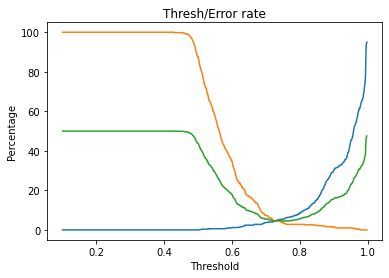

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       195
           1       1.00      1.00      1.00       215
           2       0.97      0.96      0.97       188
           3       0.97      0.97      0.97       191
           4       0.88      0.89      0.89       204
           5       1.00      1.00      1.00       204
           6       0.94      0.80      0.86       199
           7       0.92      1.00      0.96       204

    accuracy                           0.95      1600
   macro avg       0.95      0.95      0.95      1600
weighted avg       0.95      0.95      0.95      1600
 
 Lowest error 0.04400000000000002
 best Thresh 0.754
iteration  100  in Epoch  0  Loss :  tensor(0.4013)  Accuracy:  83.1875
iteration  100  in Epoch  1  Loss :  tensor(0.1341)  Accuracy:  92.875
iteration  100  in Epoch  2  Loss :  tensor(0.2782)  Accuracy:  94.125


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


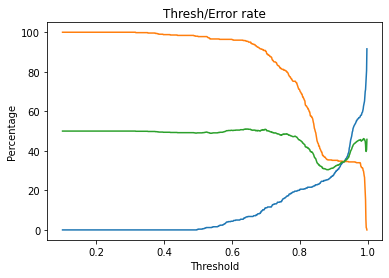

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       195
           1       0.99      1.00      1.00       215
           2       0.91      0.99      0.95       188
           3       0.97      0.80      0.88       191
           4       0.89      0.81      0.85       204
           5       1.00      1.00      1.00       204
           6       0.97      0.86      0.91       199
           7       0.86      1.00      0.92       204

    accuracy                           0.93      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.94      0.93      0.93      1600
 
 Lowest error 0.30399999999999994
 best Thresh 0.883
iteration  100  in Epoch  0  Loss :  tensor(0.7742)  Accuracy:  81.72222222222223
iteration  100  in Epoch  1  Loss :  tensor(0.5565)  Accuracy:  92.5
iteration  100  in Epoch  2  Loss :  tensor(0.2459)  Accuracy:  91.0


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


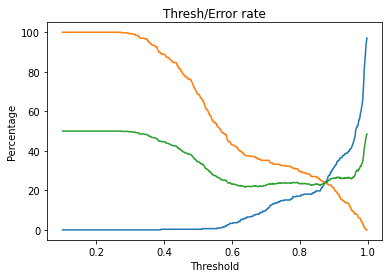

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       199
           1       1.00      1.00      1.00       216
           2       0.99      0.92      0.95       181
           3       0.95      0.87      0.91       184
           4       0.82      0.91      0.86       196
           5       1.00      1.00      1.00       218
           6       0.95      0.75      0.84       187
           7       0.90      1.00      0.95       210
           8       0.92      1.00      0.96       209

    accuracy                           0.94      1800
   macro avg       0.94      0.93      0.93      1800
weighted avg       0.94      0.94      0.94      1800
 
 Lowest error 0.21710526315789472
 best Thresh 0.637


/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(0.5928)  Accuracy:  77.42857142857143
iteration  200  in Epoch  0  Loss :  tensor(0.3212)  Accuracy:  92.22857142857143
iteration  100  in Epoch  1  Loss :  tensor(0.2286)  Accuracy:  93.6
iteration  200  in Epoch  1  Loss :  tensor(0.2073)  Accuracy:  93.82857142857142
iteration  100  in Epoch  2  Loss :  tensor(0.1269)  Accuracy:  94.17142857142858
iteration  200  in Epoch  2  Loss :  tensor(0.1949)  Accuracy:  95.05714285714286


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


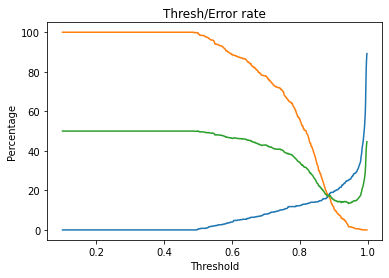

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       0.99      0.86      0.92       487
           2       0.91      0.97      0.94       494
           3       1.00      0.99      1.00       470
           4       0.98      0.78      0.87       518
           5       0.88      1.00      0.94       495
           6       0.88      1.00      0.94       523

    accuracy                           0.94      3500
   macro avg       0.95      0.94      0.94      3500
weighted avg       0.95      0.94      0.94      3500
 
 Lowest error 0.13299999999999998
 best Thresh 0.944
iteration  100  in Epoch  0  Loss :  tensor(0.4151)  Accuracy:  87.05714285714286
iteration  200  in Epoch  0  Loss :  tensor(0.2805)  Accuracy:  91.91428571428571
iteration  100  in Epoch  1  Loss :  tensor(0.3715)  Accuracy:  88.0
iteration  200  in Epoch  1  Loss :  tensor(0.2649)  Accuracy:  93.17142857142858
iteration  100  in Epoch  2  Loss 

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


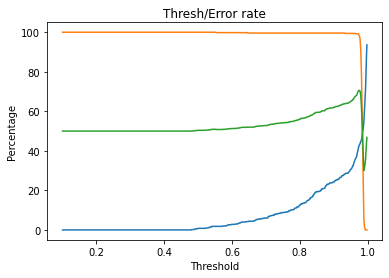

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       513
           1       0.97      0.92      0.94       487
           2       0.84      0.97      0.90       494
           3       1.00      0.99      0.99       470
           4       0.99      0.80      0.89       518
           5       0.93      0.98      0.95       495
           6       0.90      1.00      0.95       523

    accuracy                           0.94      3500
   macro avg       0.95      0.94      0.94      3500
weighted avg       0.95      0.94      0.94      3500
 
 Lowest error 0.30100000000000005
 best Thresh 0.989
iteration  100  in Epoch  0  Loss :  tensor(0.4902)  Accuracy:  82.65
iteration  200  in Epoch  0  Loss :  tensor(0.1510)  Accuracy:  92.0
iteration  300  in Epoch  0  Loss :  tensor(0.1990)  Accuracy:  93.25
iteration  100  in Epoch  1  Loss :  tensor(0.1765)  Accuracy:  92.375
iteration  200  in Epoch  1  Loss :  tensor(0.2235)  Accuracy:  91.8


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


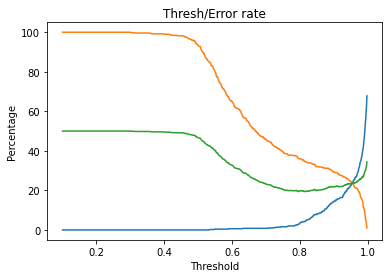

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       532
           1       1.00      1.00      1.00       490
           2       0.98      0.80      0.88       491
           3       0.89      0.91      0.90       496
           4       1.00      1.00      1.00       521
           5       0.98      0.79      0.88       505
           6       0.84      1.00      0.91       494
           7       0.92      0.99      0.95       471

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000
 
 Lowest error 0.19399999999999995
 best Thresh 0.816
iteration  100  in Epoch  0  Loss :  tensor(0.3834)  Accuracy:  92.4
iteration  200  in Epoch  0  Loss :  tensor(0.2637)  Accuracy:  94.57142857142857
iteration  100  in Epoch  1  Loss :  tensor(0.0556)  Accuracy:  94.82857142857142
iteration  200  in Epoch  1  Loss :  tensor(0.3698)  Accuracy:

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


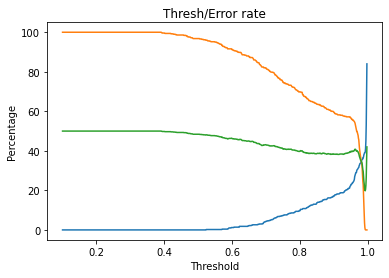

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       513
           1       1.00      1.00      1.00       487
           2       0.86      0.98      0.91       494
           3       1.00      0.99      1.00       470
           4       0.96      0.85      0.90       518
           5       1.00      1.00      1.00       495
           6       0.94      0.98      0.96       523

    accuracy                           0.96      3500
   macro avg       0.96      0.96      0.96      3500
weighted avg       0.96      0.96      0.96      3500
 
 Lowest error 0.198
 best Thresh 0.993
iteration  100  in Epoch  0  Loss :  tensor(0.3477)  Accuracy:  93.28571428571429
iteration  200  in Epoch  0  Loss :  tensor(0.0919)  Accuracy:  94.08571428571429
iteration  100  in Epoch  1  Loss :  tensor(0.2493)  Accuracy:  94.74285714285715
iteration  200  in Epoch  1  Loss :  tensor(0.1437)  Accuracy:  95.25714285714285
iteration  100  in Epoch  2  Loss :

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


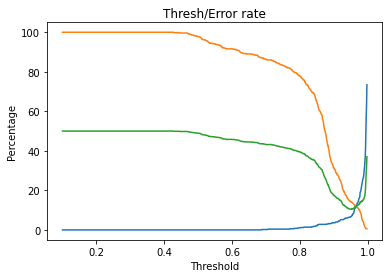

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       513
           1       1.00      1.00      1.00       487
           2       1.00      0.82      0.90       494
           3       1.00      1.00      1.00       470
           4       0.99      0.86      0.92       518
           5       0.85      1.00      0.92       495
           6       0.89      1.00      0.94       523

    accuracy                           0.95      3500
   macro avg       0.96      0.95      0.95      3500
weighted avg       0.96      0.95      0.95      3500
 
 Lowest error 0.10400000000000002
 best Thresh 0.951
iteration  100  in Epoch  0  Loss :  tensor(0.5364)  Accuracy:  87.28571428571429
iteration  200  in Epoch  0  Loss :  tensor(0.2555)  Accuracy:  91.28571428571429
iteration  100  in Epoch  1  Loss :  tensor(0.3271)  Accuracy:  92.68571428571428
iteration  200  in Epoch  1  Loss :  tensor(0.3365)  Accuracy:  92.54285714285714
iteration  100  in Ep

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


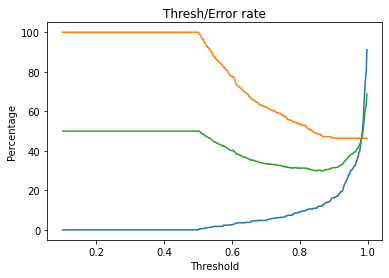

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       513
           1       1.00      1.00      1.00       487
           2       0.94      0.94      0.94       494
           3       0.85      0.97      0.90       470
           4       0.99      0.78      0.87       518
           5       0.94      0.96      0.95       495
           6       0.89      1.00      0.94       523

    accuracy                           0.94      3500
   macro avg       0.94      0.94      0.94      3500
weighted avg       0.94      0.94      0.94      3500
 
 Lowest error 0.299
 best Thresh 0.862
iteration  100  in Epoch  0  Loss :  tensor(0.2680)  Accuracy:  93.68571428571428
iteration  200  in Epoch  0  Loss :  tensor(0.2595)  Accuracy:  90.31428571428572
iteration  100  in Epoch  1  Loss :  tensor(0.1061)  Accuracy:  95.25714285714285
iteration  200  in Epoch  1  Loss :  tensor(0.0285)  Accuracy:  95.82857142857142
iteration  100  in Epoch  2  Loss :

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


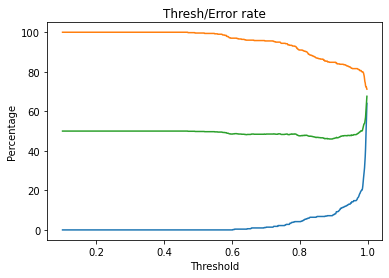

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       513
           1       1.00      1.00      1.00       487
           2       0.98      0.83      0.90       494
           3       0.94      0.98      0.96       470
           4       1.00      1.00      1.00       518
           5       0.85      1.00      0.92       495
           6       1.00      1.00      1.00       523

    accuracy                           0.96      3500
   macro avg       0.97      0.96      0.96      3500
weighted avg       0.97      0.96      0.96      3500
 
 Lowest error 0.46
 best Thresh 0.887
iteration  100  in Epoch  0  Loss :  tensor(0.5845)  Accuracy:  84.22857142857143
iteration  200  in Epoch  0  Loss :  tensor(0.2945)  Accuracy:  94.34285714285714
iteration  100  in Epoch  1  Loss :  tensor(0.2448)  Accuracy:  93.88571428571429
iteration  200  in Epoch  1  Loss :  tensor(0.2999)  Accuracy:  92.82857142857142
iteration  100  in Epoch  2  Loss : 

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


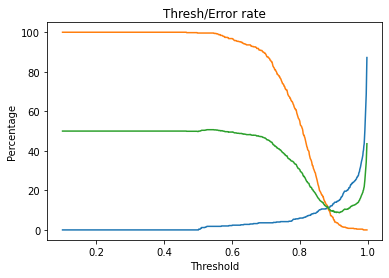

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       513
           1       1.00      1.00      1.00       487
           2       0.98      1.00      0.99       494
           3       0.90      0.94      0.92       470
           4       1.00      1.00      1.00       518
           5       0.96      0.80      0.88       495
           6       0.91      0.98      0.94       523

    accuracy                           0.96      3500
   macro avg       0.96      0.96      0.96      3500
weighted avg       0.96      0.96      0.96      3500
 
 Lowest error 0.08700000000000002
 best Thresh 0.917
iteration  100  in Epoch  0  Loss :  tensor(0.4485)  Accuracy:  85.31428571428572
iteration  200  in Epoch  0  Loss :  tensor(0.2832)  Accuracy:  88.88571428571429
iteration  100  in Epoch  1  Loss :  tensor(0.0604)  Accuracy:  93.97142857142858
iteration  200  in Epoch  1  Loss :  tensor(0.0850)  Accuracy:  94.45714285714286
iteration  100  in Ep

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


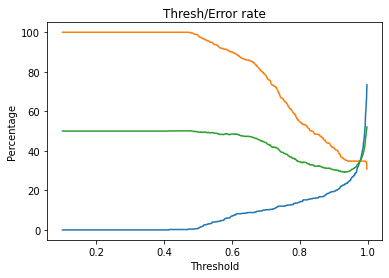

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       513
           1       1.00      1.00      1.00       487
           2       0.98      0.84      0.91       494
           3       0.89      0.90      0.89       470
           4       1.00      1.00      1.00       518
           5       0.92      0.93      0.92       495
           6       0.87      1.00      0.93       523

    accuracy                           0.95      3500
   macro avg       0.95      0.95      0.95      3500
weighted avg       0.95      0.95      0.95      3500
 
 Lowest error 0.293
 best Thresh 0.93
iteration  100  in Epoch  0  Loss :  tensor(0.3952)  Accuracy:  88.4
iteration  200  in Epoch  0  Loss :  tensor(0.2196)  Accuracy:  91.7
iteration  300  in Epoch  0  Loss :  tensor(0.1726)  Accuracy:  90.6
iteration  100  in Epoch  1  Loss :  tensor(0.2692)  Accuracy:  92.9
iteration  200  in Epoch  1  Loss :  tensor(0.1169)  Accuracy:  90.875
iteration  300  i

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


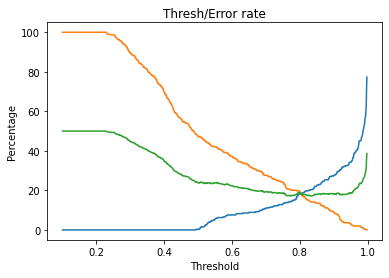

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       532
           1       1.00      1.00      1.00       490
           2       0.81      1.00      0.90       491
           3       0.86      0.97      0.91       496
           4       1.00      1.00      1.00       521
           5       0.86      0.86      0.86       505
           6       1.00      0.79      0.88       494
           7       0.98      0.86      0.91       471

    accuracy                           0.93      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.94      0.93      0.93      4000
 
 Lowest error 0.17105263157894737
 best Thresh 0.831


/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(0.3590)  Accuracy:  77.65714285714286
iteration  200  in Epoch  0  Loss :  tensor(0.2408)  Accuracy:  93.22857142857143
iteration  300  in Epoch  0  Loss :  tensor(0.2606)  Accuracy:  93.05714285714286
iteration  400  in Epoch  0  Loss :  tensor(0.1060)  Accuracy:  93.47142857142858
iteration  500  in Epoch  0  Loss :  tensor(0.1541)  Accuracy:  93.8
iteration  100  in Epoch  1  Loss :  tensor(0.1625)  Accuracy:  95.14285714285714
iteration  200  in Epoch  1  Loss :  tensor(0.0751)  Accuracy:  92.64285714285714
iteration  300  in Epoch  1  Lo

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


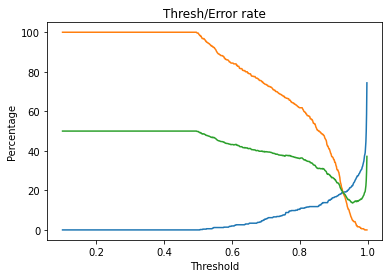

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1020
           1       0.88      1.00      0.93      1010
           2       0.91      0.98      0.95       991
           3       1.00      1.00      1.00       969
           4       1.00      0.82      0.90      1016
           5       1.00      0.88      0.93      1005
           6       0.92      1.00      0.96       989

    accuracy                           0.95      7000
   macro avg       0.96      0.95      0.95      7000
weighted avg       0.96      0.95      0.95      7000
 
 Lowest error 0.13600000000000007
 best Thresh 0.956
iteration  100  in Epoch  0  Loss :  tensor(0.4670)  Accuracy:  90.65
iteration  200  in Epoch  0  Loss :  tensor(0.1453)  Accuracy:  92.18333333333334
iteration  300  in Epoch  0  Loss :  tensor(0.1697)  Accuracy:  91.28333333333333
iteration  400  in Epoch  0  Loss :  tensor(0.1710)  Accuracy:  93.0
iteration  100  in Epoch  1  Loss :  tensor(0.

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


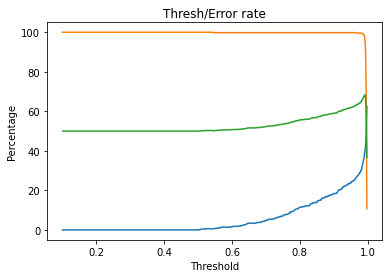

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1023
           1       0.89      0.98      0.94      1007
           2       1.00      1.00      1.00       977
           3       0.99      0.82      0.90      1000
           4       0.88      1.00      0.94       994
           5       0.94      1.00      0.97       999

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.95      0.94      0.94      6000
 
 Lowest error 0.36599999999999994
 best Thresh 0.998
iteration  100  in Epoch  0  Loss :  tensor(0.4386)  Accuracy:  90.11428571428571
iteration  200  in Epoch  0  Loss :  tensor(0.1803)  Accuracy:  93.2
iteration  300  in Epoch  0  Loss :  tensor(0.1529)  Accuracy:  94.15714285714286
iteration  400  in Epoch  0  Loss :  tensor(0.1218)  Accuracy:  93.45714285714286
iteration  500  in Epoch  0  Loss :  tensor(0.1024)  Accuracy:  93.72857142857143
iterat

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


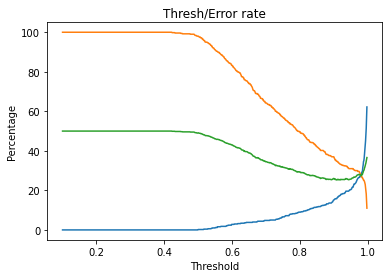

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1020
           1       0.96      0.96      0.96      1010
           2       0.91      0.98      0.95       991
           3       1.00      1.00      1.00       969
           4       0.96      0.87      0.91      1016
           5       0.96      0.97      0.96      1005
           6       0.96      0.96      0.96       989

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000
 
 Lowest error 0.25299999999999995
 best Thresh 0.908
iteration  100  in Epoch  0  Loss :  tensor(0.2616)  Accuracy:  92.48333333333333
iteration  200  in Epoch  0  Loss :  tensor(0.2071)  Accuracy:  95.11666666666666
iteration  300  in Epoch  0  Loss :  tensor(0.0763)  Accuracy:  95.58333333333333
iteration  400  in Epoch  0  Loss :  tensor(0.0200)  Accuracy:  95.61666666666666
iteration  100  in Ep

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


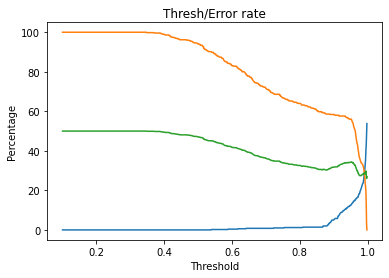

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.89      1.00      0.94      1007
           2       1.00      1.00      1.00       977
           3       1.00      0.79      0.88      1000
           4       1.00      1.00      1.00       994
           5       0.91      1.00      0.96       999

    accuracy                           0.96      6000
   macro avg       0.97      0.96      0.96      6000
weighted avg       0.97      0.96      0.96      6000
 
 Lowest error 0.26
 best Thresh 0.997
iteration  100  in Epoch  0  Loss :  tensor(0.2792)  Accuracy:  93.58333333333333
iteration  200  in Epoch  0  Loss :  tensor(0.2168)  Accuracy:  94.15
iteration  300  in Epoch  0  Loss :  tensor(0.1893)  Accuracy:  95.08333333333333
iteration  400  in Epoch  0  Loss :  tensor(0.1224)  Accuracy:  94.53333333333333
iteration  100  in Epoch  1  Loss :  tensor(0.0387)  Accuracy:  95.71666666666667
iteration  200  in E

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


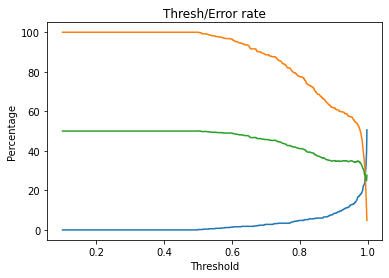

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.95      0.98      0.96      1007
           2       1.00      1.00      1.00       977
           3       1.00      0.93      0.96      1000
           4       0.97      0.95      0.96       994
           5       0.94      1.00      0.97       999

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000
 
 Lowest error 0.24899999999999994
 best Thresh 0.997
iteration  100  in Epoch  0  Loss :  tensor(0.5842)  Accuracy:  74.45
iteration  200  in Epoch  0  Loss :  tensor(0.1380)  Accuracy:  92.2
iteration  300  in Epoch  0  Loss :  tensor(0.2372)  Accuracy:  93.51666666666667
iteration  400  in Epoch  0  Loss :  tensor(0.2057)  Accuracy:  92.63333333333334
iteration  100  in Epoch  1  Loss :  tensor(0.1411)  Accuracy:  94.41666666666667
iteration  200  in

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


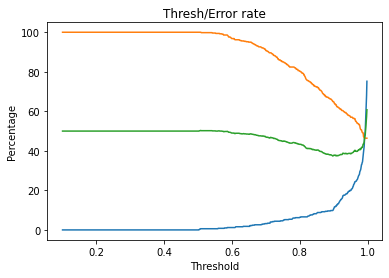

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.97      0.92      0.94      1007
           2       0.89      0.99      0.94       977
           3       1.00      0.81      0.90      1000
           4       0.92      0.99      0.95       994
           5       0.94      1.00      0.97       999

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000
 
 Lowest error 0.374
 best Thresh 0.897
iteration  100  in Epoch  0  Loss :  tensor(0.2365)  Accuracy:  94.3
iteration  200  in Epoch  0  Loss :  tensor(0.1970)  Accuracy:  89.78333333333333
iteration  300  in Epoch  0  Loss :  tensor(0.1356)  Accuracy:  96.86666666666666
iteration  400  in Epoch  0  Loss :  tensor(0.1098)  Accuracy:  96.96666666666667
iteration  100  in Epoch  1  Loss :  tensor(0.0804)  Accuracy:  97.01666666666667
iteration  200  in E

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


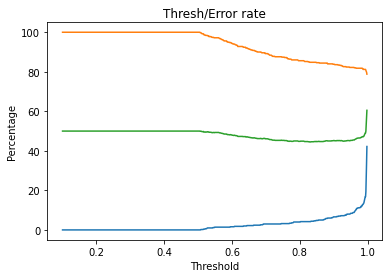

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.94      0.97      0.96      1007
           2       0.99      0.99      0.99       977
           3       1.00      1.00      1.00      1000
           4       0.97      0.95      0.96       994
           5       1.00      1.00      1.00       999

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000
 
 Lowest error 0.445
 best Thresh 0.829
iteration  100  in Epoch  0  Loss :  tensor(0.3948)  Accuracy:  93.8
iteration  200  in Epoch  0  Loss :  tensor(0.2354)  Accuracy:  94.98333333333333
iteration  300  in Epoch  0  Loss :  tensor(0.1154)  Accuracy:  94.86666666666666
iteration  400  in Epoch  0  Loss :  tensor(0.2873)  Accuracy:  95.05
iteration  100  in Epoch  1  Loss :  tensor(0.0806)  Accuracy:  96.38333333333334
iteration  200  in Epoch  1  Los

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


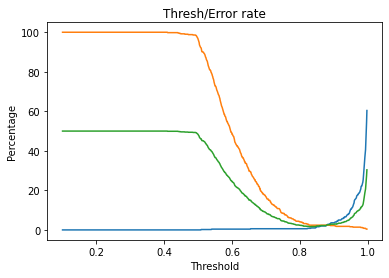

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.99      1.00      0.99      1007
           2       0.89      0.99      0.94       977
           3       1.00      0.99      1.00      1000
           4       1.00      0.78      0.88       994
           5       0.90      1.00      0.95       999

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000
 
 Lowest error 0.016000000000000028
 best Thresh 0.828
iteration  100  in Epoch  0  Loss :  tensor(0.2907)  Accuracy:  93.18333333333334
iteration  200  in Epoch  0  Loss :  tensor(0.2170)  Accuracy:  93.88333333333334
iteration  300  in Epoch  0  Loss :  tensor(0.2160)  Accuracy:  92.7
iteration  400  in Epoch  0  Loss :  tensor(0.1612)  Accuracy:  95.48333333333333
iteration  100  in Epoch  1  Loss :  tensor(0.2118)  Accuracy:  95.53333333333333
itera

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


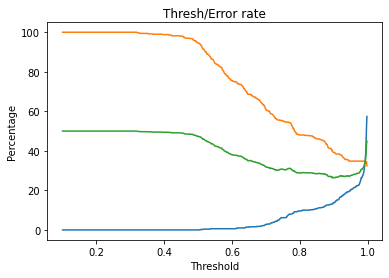

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.98      0.90      0.94      1007
           2       0.90      0.99      0.94       977
           3       1.00      1.00      1.00      1000
           4       1.00      0.89      0.94       994
           5       0.91      0.99      0.95       999

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000
 
 Lowest error 0.264
 best Thresh 0.903
iteration  100  in Epoch  0  Loss :  tensor(0.4652)  Accuracy:  83.85714285714286
iteration  200  in Epoch  0  Loss :  tensor(0.2584)  Accuracy:  92.37142857142857
iteration  300  in Epoch  0  Loss :  tensor(0.2150)  Accuracy:  93.57142857142857
iteration  400  in Epoch  0  Loss :  tensor(0.1733)  Accuracy:  94.91428571428571
iteration  500  in Epoch  0  Loss :  tensor(0.1077)  Accuracy:  94.25714285714285
iterati

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


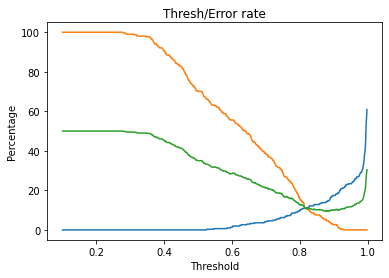

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1020
           1       0.92      0.98      0.95      1010
           2       0.91      0.97      0.94       991
           3       1.00      1.00      1.00       969
           4       1.00      0.84      0.91      1016
           5       0.98      0.94      0.96      1005
           6       0.93      1.00      0.97       989

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000
 
 Lowest error 0.09374999999999999
 best Thresh 0.887


/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(0.2715)  Accuracy:  93.925
iteration  200  in Epoch  0  Loss :  tensor(0.0996)  Accuracy:  95.5
iteration  300  in Epoch  0  Loss :  tensor(0.1840)  Accuracy:  92.13333333333334
iteration  400  in Epoch  0  Loss :  tensor(0.1440)  Accuracy:  95.93333333333334
iteration  500  in Epoch  0  Loss :  tensor(0.0997)  Accuracy:  96.45833333333333
iteration  600  in Epoch  0  Loss :  tensor(0.1004)  Accuracy:  96.75833333333334
iteration  700  in Epoch  0  Loss :  tensor(0.0953)  Accuracy:  96.16666666666667
iteration  800  in Epoch  0  Loss :  tenso

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


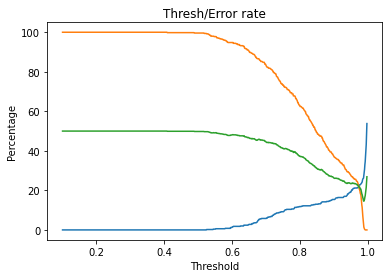

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2089
           1       0.99      1.00      1.00      1940
           2       0.92      0.99      0.95      1992
           3       1.00      1.00      1.00      1959
           4       0.96      0.88      0.92      2050
           5       0.96      0.97      0.97      1970

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000
 
 Lowest error 0.14500000000000005
 best Thresh 0.989
iteration  100  in Epoch  0  Loss :  tensor(0.3387)  Accuracy:  89.95
iteration  200  in Epoch  0  Loss :  tensor(0.1017)  Accuracy:  94.66
iteration  300  in Epoch  0  Loss :  tensor(0.1806)  Accuracy:  95.37
iteration  400  in Epoch  0  Loss :  tensor(0.1521)  Accuracy:  95.49
iteration  500  in Epoch  0  Loss :  tensor(0.2313)  Accuracy:  89.86
iteration  600  in Epoch  0  Loss :  tensor(0.1173)  

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


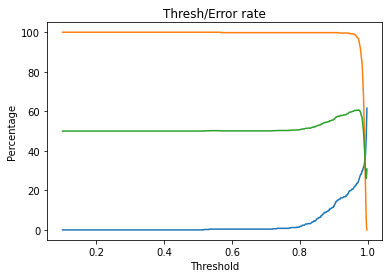

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2062
           1       0.92      0.99      0.95      2083
           2       1.00      1.00      1.00      1920
           3       1.00      0.84      0.91      1910
           4       0.94      1.00      0.97      2025

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000
 
 Lowest error 0.26100000000000007
 best Thresh 0.996
iteration  100  in Epoch  0  Loss :  tensor(0.3542)  Accuracy:  89.80833333333334
iteration  200  in Epoch  0  Loss :  tensor(0.1942)  Accuracy:  95.23333333333333
iteration  300  in Epoch  0  Loss :  tensor(0.0904)  Accuracy:  95.73333333333333
iteration  400  in Epoch  0  Loss :  tensor(0.2172)  Accuracy:  95.78333333333333
iteration  500  in Epoch  0  Loss :  tensor(0.2834)  Accuracy:  96.09166666666667
iteration  600  in Epoch  0  Loss :  tensor(0.0

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


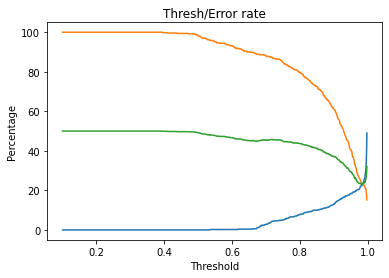

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2089
           1       0.99      1.00      0.99      1940
           2       0.92      0.99      0.95      1992
           3       1.00      1.00      1.00      1959
           4       0.99      0.86      0.92      2050
           5       0.94      1.00      0.97      1970

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000
 
 Lowest error 0.22900000000000006
 best Thresh 0.982
iteration  100  in Epoch  0  Loss :  tensor(0.1072)  Accuracy:  94.71
iteration  200  in Epoch  0  Loss :  tensor(0.1861)  Accuracy:  95.41
iteration  300  in Epoch  0  Loss :  tensor(0.1936)  Accuracy:  95.71
iteration  400  in Epoch  0  Loss :  tensor(0.1286)  Accuracy:  91.41
iteration  500  in Epoch  0  Loss :  tensor(0.1542)  Accuracy:  96.31
iteration  600  in Epoch  0  Loss :  tensor(0.2258)  

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


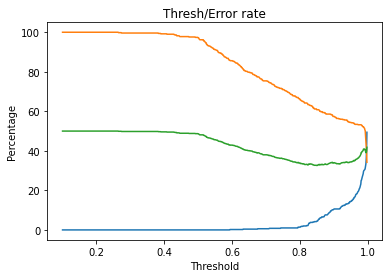

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2062
           1       0.92      1.00      0.96      2083
           2       1.00      1.00      1.00      1920
           3       1.00      0.84      0.91      1910
           4       0.94      1.00      0.97      2025

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000
 
 Lowest error 0.326
 best Thresh 0.85
iteration  100  in Epoch  0  Loss :  tensor(0.2098)  Accuracy:  96.54
iteration  200  in Epoch  0  Loss :  tensor(0.1174)  Accuracy:  97.01
iteration  300  in Epoch  0  Loss :  tensor(0.1299)  Accuracy:  97.15
iteration  400  in Epoch  0  Loss :  tensor(0.0855)  Accuracy:  98.08
iteration  500  in Epoch  0  Loss :  tensor(0.0153)  Accuracy:  97.67
iteration  600  in Epoch  0  Loss :  tensor(0.1197)  Accuracy:  97.75
iteration  700  in Epoch  0  Loss :  tensor(0.0656) 

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


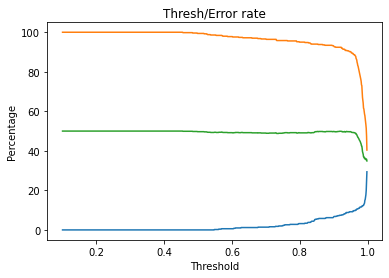

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2062
           1       1.00      1.00      1.00      2083
           2       1.00      1.00      1.00      1920
           3       0.99      0.95      0.97      1910
           4       0.96      0.99      0.97      2025

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 
 Lowest error 0.34900000000000003
 best Thresh 0.998
iteration  100  in Epoch  0  Loss :  tensor(0.3989)  Accuracy:  91.16
iteration  200  in Epoch  0  Loss :  tensor(0.0778)  Accuracy:  94.94
iteration  300  in Epoch  0  Loss :  tensor(0.1332)  Accuracy:  94.93
iteration  400  in Epoch  0  Loss :  tensor(0.1605)  Accuracy:  95.3
iteration  500  in Epoch  0  Loss :  tensor(0.0833)  Accuracy:  95.68
iteration  600  in Epoch  0  Loss :  tensor(0.2559)  Accuracy:  95.69
iteration  700  in Epoch  0  Loss :  t

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


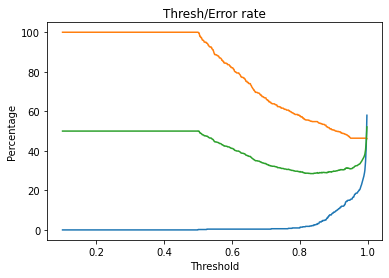

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2062
           1       0.99      1.00      0.99      2083
           2       0.91      0.99      0.95      1920
           3       0.99      0.84      0.91      1910
           4       0.94      1.00      0.97      2025

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000
 
 Lowest error 0.285
 best Thresh 0.831
iteration  100  in Epoch  0  Loss :  tensor(0.0925)  Accuracy:  98.43
iteration  200  in Epoch  0  Loss :  tensor(0.0440)  Accuracy:  99.39
iteration  300  in Epoch  0  Loss :  tensor(0.0112)  Accuracy:  99.44
iteration  400  in Epoch  0  Loss :  tensor(0.0443)  Accuracy:  99.57
iteration  500  in Epoch  0  Loss :  tensor(0.0046)  Accuracy:  99.61
iteration  600  in Epoch  0  Loss :  tensor(0.0061)  Accuracy:  99.6
iteration  700  in Epoch  0  Loss :  tensor(0.0030) 

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


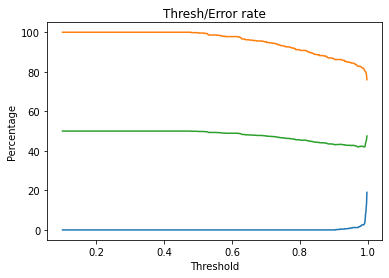

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2062
           1       0.99      1.00      1.00      2083
           2       1.00      0.99      0.99      1920
           3       1.00      1.00      1.00      1910
           4       1.00      1.00      1.00      2025

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000
 
 Lowest error 0.42
 best Thresh 0.971
iteration  100  in Epoch  0  Loss :  tensor(0.4016)  Accuracy:  93.45
iteration  200  in Epoch  0  Loss :  tensor(0.1367)  Accuracy:  95.275
iteration  300  in Epoch  0  Loss :  tensor(0.2146)  Accuracy:  95.6
iteration  400  in Epoch  0  Loss :  tensor(0.2593)  Accuracy:  96.40833333333333
iteration  500  in Epoch  0  Loss :  tensor(0.0304)  Accuracy:  96.14166666666667
iteration  600  in Epoch  0  Loss :  tensor(0.0622)  Accuracy:  96.04166666666667
iteration  700  

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


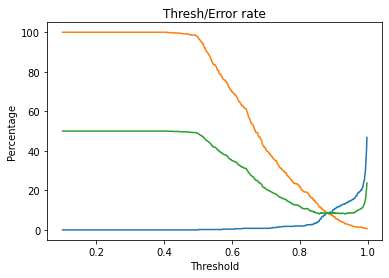

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2089
           1       0.99      1.00      1.00      1940
           2       0.92      0.99      0.95      1992
           3       1.00      1.00      1.00      1959
           4       0.99      0.86      0.92      2050
           5       0.95      1.00      0.97      1970

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000
 
 Lowest error 0.07999999999999996
 best Thresh 0.857
iteration  100  in Epoch  0  Loss :  tensor(0.2525)  Accuracy:  96.57
iteration  200  in Epoch  0  Loss :  tensor(0.1510)  Accuracy:  96.91
iteration  300  in Epoch  0  Loss :  tensor(0.0800)  Accuracy:  97.06
iteration  400  in Epoch  0  Loss :  tensor(0.0971)  Accuracy:  97.34
iteration  500  in Epoch  0  Loss :  tensor(0.0803)  Accuracy:  97.65
iteration  600  in Epoch  0  Loss :  tensor(0.0960)  

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


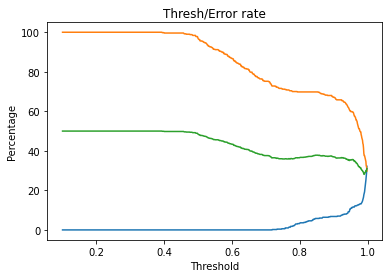

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2062
           1       1.00      1.00      1.00      2083
           2       0.91      0.99      0.95      1920
           3       1.00      1.00      1.00      1910
           4       0.99      0.91      0.95      2025

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000
 
 Lowest error 0.281
 best Thresh 0.99
iteration  100  in Epoch  0  Loss :  tensor(0.4492)  Accuracy:  88.70833333333333
iteration  200  in Epoch  0  Loss :  tensor(0.1173)  Accuracy:  95.63333333333334
iteration  300  in Epoch  0  Loss :  tensor(0.1148)  Accuracy:  95.69166666666666
iteration  400  in Epoch  0  Loss :  tensor(0.1805)  Accuracy:  95.95
iteration  500  in Epoch  0  Loss :  tensor(0.1253)  Accuracy:  96.0
iteration  600  in Epoch  0  Loss :  tensor(0.0755)  Accuracy:  96.225
iteration  700  

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


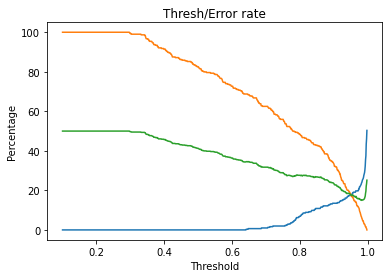

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2089
           1       0.99      1.00      0.99      1940
           2       0.92      0.99      0.95      1992
           3       1.00      1.00      1.00      1959
           4       0.99      0.86      0.92      2050
           5       0.95      1.00      0.97      1970

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000
 
 Lowest error 0.1496710526315789
 best Thresh 0.981


In [21]:
create_MLP_experiment_balanced('../Results/MLP-BALANCED/class 2/')

In [23]:
def MLP_imbalanced_experiment(min_rec,PATHH):
    df = DatasetHandler()
    err_li = []
    trained_loops = 0 
    for i in range(10):
        path = PATHH + df.encoded_labels[i] + '/'+ df.encoded_labels[i] 
        X,x,Y,y,dell = df.get_imbalanced_splits(i,min_rec)
        if(type(X) == int):
            continue
        num_of_classes = len(np.unique(Y))
        err_li.append(mlp_train(i,num_of_classes,X,x,Y,y,dell,path))
        trained_loops = trained_loops + 1 
 
    with open('{}ERROR RATE.txt'.format(PATHH), 'w') as f:
        f.write(str(sum(err_li)/trained_loops))

In [24]:
def create_MLP_experiment_imbalanced(path):
    for i in [300,3000]:
        PATHH = path + '{}'.format(i) + '/'
        MLP_imbalanced_experiment(i,PATHH)

/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(1.0233)  Accuracy:  84.3479809392808
iteration  200  in Epoch  0  Loss :  tensor(0.3098)  Accuracy:  92.41501277264689
iteration  300  in Epoch  0  Loss :  tensor(0.2339)  Accuracy:  91.98393594026331
iteration  400  in Epoch  0  Loss :  tensor(0.1693)  Accuracy:  94.61460994301434
iteration  500  in Epoch  0  Loss :  tensor(0.3652)  Accuracy:  91.76962566319513
iteration  600  in Epoch  0  Loss :  tensor(0.0813)  Accuracy:  94.04782373747298
iteration  700  in Epoch  0  Loss :  tensor(0.2598)  Accuracy:  94.67110434269995
iteration  800  in 

iteration  9600  in Epoch  0  Loss :  tensor(0.0751)  Accuracy:  97.01132344271959
iteration  9700  in Epoch  0  Loss :  tensor(0.1414)  Accuracy:  97.17098152878758
iteration  9800  in Epoch  0  Loss :  tensor(0.2439)  Accuracy:  97.09483690312439
iteration  9900  in Epoch  0  Loss :  tensor(0.0560)  Accuracy:  97.16115641579879
iteration  10000  in Epoch  0  Loss :  tensor(0.0089)  Accuracy:  97.21642267636078
iteration  10100  in Epoch  0  Loss :  tensor(0.1089)  Accuracy:  97.14764688543919
iteration  10200  in Epoch  0  Loss :  tensor(0.0347)  Accuracy:  97.06229121634898
iteration  10300  in Epoch  0  Loss :  tensor(0.0900)  Accuracy:  97.01623599921399
iteration  10400  in Epoch  0  Loss :  tensor(0.0241)  Accuracy:  96.76569561799961
iteration  10500  in Epoch  0  Loss :  tensor(0.0431)  Accuracy:  96.9020190607192
iteration  10600  in Epoch  0  Loss :  tensor(0.0443)  Accuracy:  97.26861858911377
iteration  10700  in Epoch  0  Loss :  tensor(0.0901)  Accuracy:  97.121241894281

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


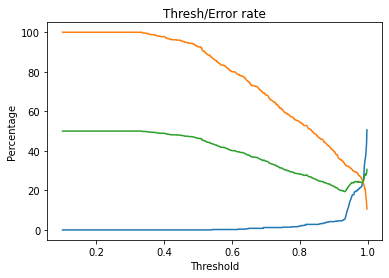

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4394
           1       0.93      0.64      0.76       232
           2       0.93      0.98      0.95      6344
           3       0.97      1.00      0.98     83818
           4       1.00      1.00      1.00     28300
           5       0.99      0.86      0.92     25290
           6       0.96      0.62      0.75      1048
           7       0.92      1.00      0.96     13359
           8       0.00      0.00      0.00        63

    accuracy                           0.97    162848
   macro avg       0.86      0.79      0.81    162848
weighted avg       0.97      0.97      0.97    162848
 
 Lowest error 0.19399999999999995
 best Thresh 0.932
iteration  100  in Epoch  0  Loss :  tensor(0.3806)  Accuracy:  89.83205434645868
iteration  200  in Epoch  0  Loss :  tensor(0.3175)  Accuracy:  92.30154736444835
iteration  300  in Epoch  0  Loss :  tensor(0.1359)  Accuracy:  94.3452006541

iteration  9100  in Epoch  0  Loss :  tensor(0.1054)  Accuracy:  96.63982890929677
iteration  9200  in Epoch  0  Loss :  tensor(0.0492)  Accuracy:  96.57126682601586
iteration  9300  in Epoch  0  Loss :  tensor(0.1730)  Accuracy:  96.3335010693169
iteration  9400  in Epoch  0  Loss :  tensor(0.0366)  Accuracy:  96.33287205937854
iteration  9500  in Epoch  0  Loss :  tensor(0.0971)  Accuracy:  96.8033714932696
iteration  9600  in Epoch  0  Loss :  tensor(0.4882)  Accuracy:  96.62158762108442
iteration  9700  in Epoch  0  Loss :  tensor(0.0830)  Accuracy:  96.49201157378286
iteration  9800  in Epoch  0  Loss :  tensor(0.0262)  Accuracy:  96.71782614165303
iteration  9900  in Epoch  0  Loss :  tensor(0.0796)  Accuracy:  96.46748018618695
iteration  10000  in Epoch  0  Loss :  tensor(0.2811)  Accuracy:  96.67253742609134
iteration  10100  in Epoch  0  Loss :  tensor(0.1773)  Accuracy:  96.26493898603599
iteration  10200  in Epoch  0  Loss :  tensor(0.1251)  Accuracy:  96.79771040382438
ite

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


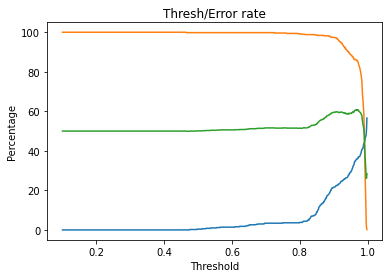

/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.51      0.32      0.39       538
           1       0.93      0.57      0.71       222
           2       0.91      0.98      0.94      6297
           3       0.97      1.00      0.98     83775
           4       1.00      1.00      1.00     28226
           5       0.99      0.86      0.92     25369
           6       0.97      0.56      0.71      1095
           7       0.92      0.99      0.95     13397
           8       0.00      0.00      0.00        61

    accuracy                           0.97    158980
   macro avg       0.80      0.70      0.73    158980
weighted avg       0.97      0.97      0.97    158980
 
 Lowest error 0.261
 best Thresh 0.996
iteration  100  in Epoch  0  Loss :  tensor(0.5106)  Accuracy:  87.62686311041381
iteration  200  in Epoch  0  Loss :  tensor(0.4431)  Accuracy:  91.32060207883899
iteration  300  in Epoch  0  Loss :  tensor(0.2717)  Accuracy:  94.00495195136301
iteration

iteration  9100  in Epoch  0  Loss :  tensor(0.1124)  Accuracy:  96.86090409884291
iteration  9200  in Epoch  0  Loss :  tensor(0.2363)  Accuracy:  96.92464208668366
iteration  9300  in Epoch  0  Loss :  tensor(0.0220)  Accuracy:  96.52321533634046
iteration  9400  in Epoch  0  Loss :  tensor(0.0314)  Accuracy:  95.48318297705433
iteration  9500  in Epoch  0  Loss :  tensor(0.0238)  Accuracy:  96.75855559913708
iteration  9600  in Epoch  0  Loss :  tensor(0.0640)  Accuracy:  96.70707491665033
iteration  9700  in Epoch  0  Loss :  tensor(0.0911)  Accuracy:  96.65436850362816
iteration  9800  in Epoch  0  Loss :  tensor(0.1133)  Accuracy:  96.7554912727986
iteration  9900  in Epoch  0  Loss :  tensor(0.1370)  Accuracy:  96.8713228083938
iteration  10000  in Epoch  0  Loss :  tensor(0.2133)  Accuracy:  96.83455089233183
iteration  10100  in Epoch  0  Loss :  tensor(0.1709)  Accuracy:  96.83087370072563
iteration  10200  in Epoch  0  Loss :  tensor(0.2441)  Accuracy:  96.79103745832516
ite

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


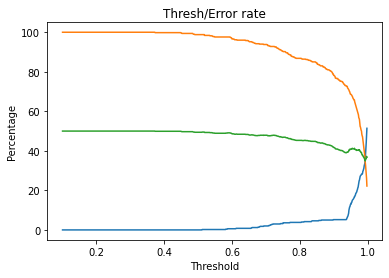

              precision    recall  f1-score   support

           0       0.45      0.06      0.11       525
           1       1.00      1.00      1.00      4423
           2       0.97      0.94      0.95      6363
           3       0.96      1.00      0.98     83916
           4       1.00      1.00      1.00     28237
           5       0.97      0.88      0.93     25249
           6       0.77      0.83      0.80      1009
           7       0.96      0.96      0.96     13382
           8       0.33      0.03      0.06        64

    accuracy                           0.97    163168
   macro avg       0.82      0.74      0.75    163168
weighted avg       0.97      0.97      0.97    163168
 
 Lowest error 0.3489999999999999
 best Thresh 0.993
iteration  100  in Epoch  0  Loss :  tensor(0.3697)  Accuracy:  85.45278647623412
iteration  200  in Epoch  0  Loss :  tensor(0.2390)  Accuracy:  91.61893123552025
iteration  300  in Epoch  0  Loss :  tensor(0.1697)  Accuracy:  94.28129534865

iteration  9100  in Epoch  0  Loss :  tensor(0.0657)  Accuracy:  97.04485857582932
iteration  9200  in Epoch  0  Loss :  tensor(0.0789)  Accuracy:  97.09323047939102
iteration  9300  in Epoch  0  Loss :  tensor(0.0672)  Accuracy:  97.00030550675933
iteration  9400  in Epoch  0  Loss :  tensor(0.1018)  Accuracy:  97.0015784515899
iteration  9500  in Epoch  0  Loss :  tensor(0.1274)  Accuracy:  96.85518979607424
iteration  9600  in Epoch  0  Loss :  tensor(0.0334)  Accuracy:  97.0766821965936
iteration  9700  in Epoch  0  Loss :  tensor(0.1495)  Accuracy:  97.0372209068459
iteration  9800  in Epoch  0  Loss :  tensor(0.0369)  Accuracy:  96.11624532192775
iteration  9900  in Epoch  0  Loss :  tensor(0.0307)  Accuracy:  97.09895873112859
iteration  10000  in Epoch  0  Loss :  tensor(0.1102)  Accuracy:  97.06140685862675
iteration  10100  in Epoch  0  Loss :  tensor(0.0284)  Accuracy:  97.06077038621146
iteration  10200  in Epoch  0  Loss :  tensor(0.1513)  Accuracy:  97.10914228977316
iter

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


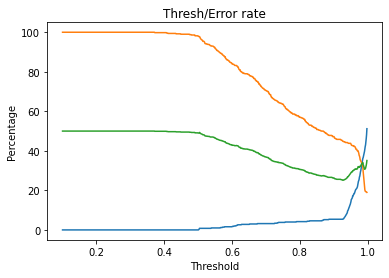

              precision    recall  f1-score   support

           0       0.39      0.05      0.09       537
           1       1.00      1.00      1.00      4388
           2       0.94      0.62      0.75       232
           3       0.97      1.00      0.98     83798
           4       1.00      1.00      1.00     28246
           5       0.92      0.90      0.91     25460
           6       0.99      0.97      0.98      1029
           7       0.97      0.86      0.91     13365
           8       0.77      0.89      0.82        61

    accuracy                           0.97    157116
   macro avg       0.88      0.81      0.83    157116
weighted avg       0.96      0.97      0.96    157116
 
 Lowest error 0.251
 best Thresh 0.927
iteration  100  in Epoch  0  Loss :  tensor(0.4765)  Accuracy:  90.19169409341005
iteration  200  in Epoch  0  Loss :  tensor(0.2130)  Accuracy:  93.97532849282717
iteration  300  in Epoch  0  Loss :  tensor(0.0919)  Accuracy:  93.82709845991508
iteration

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


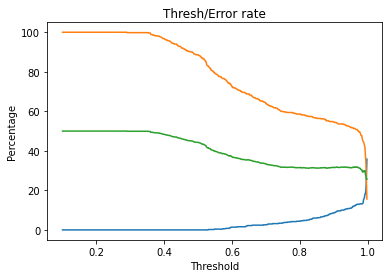

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       515
           1       1.00      1.00      1.00      4412
           2       0.98      0.57      0.73       228
           3       0.98      0.92      0.95      6290
           4       1.00      1.00      1.00     28267
           5       0.99      0.95      0.97     25157
           6       0.68      0.95      0.79      1083
           7       0.92      0.99      0.95     13589
           8       1.00      0.98      0.99        65

    accuracy                           0.97     79606
   macro avg       0.94      0.92      0.92     79606
weighted avg       0.98      0.97      0.97     79606
 
 Lowest error 0.256
 best Thresh 0.997
iteration  100  in Epoch  0  Loss :  tensor(0.5743)  Accuracy:  84.77414963973428
iteration  200  in Epoch  0  Loss :  tensor(0.3282)  Accuracy:  91.96170974566867
iteration  300  in Epoch  0  Loss :  tensor(0.2094)  Accuracy:  91.19383331607214
iteration

iteration  9100  in Epoch  0  Loss :  tensor(0.0886)  Accuracy:  96.01340454807735
iteration  9200  in Epoch  0  Loss :  tensor(0.0865)  Accuracy:  96.26492476586427
iteration  9300  in Epoch  0  Loss :  tensor(0.0671)  Accuracy:  96.26048617378568
iteration  9400  in Epoch  0  Loss :  tensor(0.0663)  Accuracy:  96.15617925993875
iteration  9500  in Epoch  0  Loss :  tensor(0.1403)  Accuracy:  95.15971533829469
iteration  9600  in Epoch  0  Loss :  tensor(0.1631)  Accuracy:  96.23607391735341
iteration  9700  in Epoch  0  Loss :  tensor(0.1408)  Accuracy:  96.27528148071431
iteration  9800  in Epoch  0  Loss :  tensor(0.0757)  Accuracy:  96.49277249256536
iteration  9900  in Epoch  0  Loss :  tensor(0.0155)  Accuracy:  96.12584888073503
iteration  10000  in Epoch  0  Loss :  tensor(0.1677)  Accuracy:  96.43211173415793
iteration  10100  in Epoch  0  Loss :  tensor(0.0533)  Accuracy:  96.20056518072468
iteration  10200  in Epoch  0  Loss :  tensor(0.1018)  Accuracy:  96.17097456686739
i

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


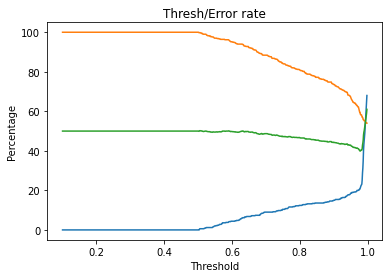

/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       546
           1       1.00      0.26      0.42      4445
           2       0.97      0.48      0.65       230
           3       0.99      0.79      0.88      6325
           4       0.76      1.00      0.86     83707
           5       0.99      0.74      0.85     25520
           6       0.00      0.00      0.00      1057
           7       0.00      0.00      0.00     13291
           8       0.00      0.00      0.00        57

    accuracy                           0.80    135178
   macro avg       0.52      0.36      0.41    135178
weighted avg       0.74      0.80      0.75    135178
 
 Lowest error 0.4
 best Thresh 0.977
iteration  100  in Epoch  0  Loss :  tensor(0.2728)  Accuracy:  91.32158909670872
iteration  200  in Epoch  0  Loss :  tensor(0.2461)  Accuracy:  96.93272437291576
iteration  300  in Epoch  0  Loss :  tensor(0.0617)  Accuracy:  97.661302015369
iteration  40

iteration  9100  in Epoch  0  Loss :  tensor(0.0011)  Accuracy:  98.96621719588227
iteration  9200  in Epoch  0  Loss :  tensor(0.0390)  Accuracy:  99.08945918515296
iteration  9300  in Epoch  0  Loss :  tensor(0.0931)  Accuracy:  98.90967087139336
iteration  9400  in Epoch  0  Loss :  tensor(0.0143)  Accuracy:  98.67478613890097
iteration  9500  in Epoch  0  Loss :  tensor(0.0097)  Accuracy:  98.94809337393069
iteration  9600  in Epoch  0  Loss :  tensor(0.0396)  Accuracy:  99.09960852544584
iteration  9700  in Epoch  0  Loss :  tensor(0.0248)  Accuracy:  98.91112077714949
iteration  9800  in Epoch  0  Loss :  tensor(0.0205)  Accuracy:  99.13440626359287
iteration  9900  in Epoch  0  Loss :  tensor(0.0107)  Accuracy:  98.99159054661447
iteration  10000  in Epoch  0  Loss :  tensor(0.0144)  Accuracy:  99.00608960417573
iteration  10100  in Epoch  0  Loss :  tensor(0.0068)  Accuracy:  98.68131071480354
iteration  10200  in Epoch  0  Loss :  tensor(0.0312)  Accuracy:  98.78787878787878
i

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


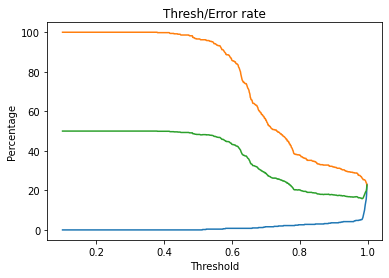

/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.25      0.01      0.01       548
           1       1.00      1.00      1.00      4449
           2       0.95      0.78      0.86       231
           3       0.95      0.97      0.96      6318
           4       0.99      1.00      0.99     83895
           5       1.00      1.00      1.00     28069
           6       0.96      0.70      0.81      1008
           7       1.00      1.00      1.00     13358
           8       0.00      0.00      0.00        64

    accuracy                           0.99    137940
   macro avg       0.79      0.72      0.74    137940
weighted avg       0.99      0.99      0.99    137940
 
 Lowest error 0.158
 best Thresh 0.984
iteration  100  in Epoch  0  Loss :  tensor(0.4360)  Accuracy:  87.53841321845805
iteration  200  in Epoch  0  Loss :  tensor(0.2428)  Accuracy:  92.54275491288898
iteration  300  in Epoch  0  Loss :  tensor(0.2056)  Accuracy:  94.42908257841223
iteration

iteration  9100  in Epoch  0  Loss :  tensor(0.2678)  Accuracy:  97.08583006423244
iteration  9200  in Epoch  0  Loss :  tensor(0.2383)  Accuracy:  97.11970143922552
iteration  9300  in Epoch  0  Loss :  tensor(0.1920)  Accuracy:  96.42071942800486
iteration  9400  in Epoch  0  Loss :  tensor(0.0770)  Accuracy:  97.10122614377475
iteration  9500  in Epoch  0  Loss :  tensor(0.0244)  Accuracy:  97.07043398469014
iteration  9600  in Epoch  0  Loss :  tensor(0.1608)  Accuracy:  97.05195868923937
iteration  9700  in Epoch  0  Loss :  tensor(0.0107)  Accuracy:  96.99961201879553
iteration  9800  in Epoch  0  Loss :  tensor(0.0272)  Accuracy:  97.02239821651814
iteration  9900  in Epoch  0  Loss :  tensor(0.0255)  Accuracy:  97.1449510096749
iteration  10000  in Epoch  0  Loss :  tensor(0.1503)  Accuracy:  97.1209331255889
iteration  10100  in Epoch  0  Loss :  tensor(0.1747)  Accuracy:  96.83148683019355
iteration  10200  in Epoch  0  Loss :  tensor(0.0802)  Accuracy:  97.0014595483406
iter

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


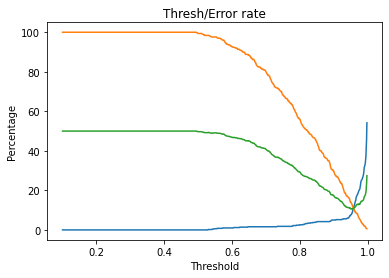

/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      0.26      0.34       527
           1       1.00      1.00      1.00      4426
           2       0.93      0.54      0.69       239
           3       0.99      0.98      0.98      6362
           4       0.97      1.00      0.98     83675
           5       1.00      1.00      1.00     28266
           6       0.99      0.86      0.92     25426
           7       0.92      0.99      0.95     13412
           8       0.00      0.00      0.00        46

    accuracy                           0.97    162379
   macro avg       0.81      0.74      0.76    162379
weighted avg       0.97      0.97      0.97    162379
 
 Lowest error 0.10600000000000001
 best Thresh 0.953
iteration  100  in Epoch  0  Loss :  tensor(0.5059)  Accuracy:  89.47828174386194
iteration  200  in Epoch  0  Loss :  tensor(0.4540)  Accuracy:  92.1628902551245
iteration  300  in Epoch  0  Loss :  tensor(0.2317)  Accuracy:  95.60100289398

iteration  9100  in Epoch  0  Loss :  tensor(0.0976)  Accuracy:  97.5427763626422
iteration  9200  in Epoch  0  Loss :  tensor(0.0817)  Accuracy:  97.4054118933625
iteration  9300  in Epoch  0  Loss :  tensor(0.1680)  Accuracy:  97.52010455703292
iteration  9400  in Epoch  0  Loss :  tensor(0.1582)  Accuracy:  97.52543909952922
iteration  9500  in Epoch  0  Loss :  tensor(0.0228)  Accuracy:  97.52877318858941
iteration  9600  in Epoch  0  Loss :  tensor(0.1509)  Accuracy:  97.47076003894216
iteration  9700  in Epoch  0  Loss :  tensor(0.0069)  Accuracy:  97.2753824200152
iteration  9800  in Epoch  0  Loss :  tensor(0.1291)  Accuracy:  97.21936972380406
iteration  9900  in Epoch  0  Loss :  tensor(0.0952)  Accuracy:  97.42875051678381
iteration  10000  in Epoch  0  Loss :  tensor(0.2296)  Accuracy:  97.40741234679861
iteration  10100  in Epoch  0  Loss :  tensor(0.0124)  Accuracy:  97.48809730205514
iteration  10200  in Epoch  0  Loss :  tensor(0.0370)  Accuracy:  97.39607644399398
iter

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


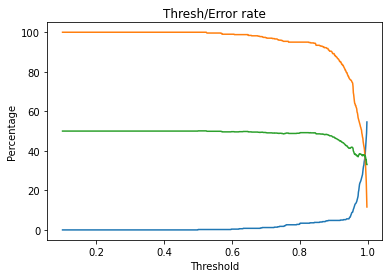

/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/john/Desktop/XIOT/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.00      0.00       534
           1       1.00      1.00      1.00      4444
           2       0.94      0.52      0.67       240
           3       0.94      0.98      0.96      6285
           4       0.96      1.00      0.98     83667
           5       1.00      0.99      1.00     28308
           6       0.99      0.91      0.95     25421
           7       0.96      0.69      0.81      1000
           8       0.00      0.00      0.00        67

    accuracy                           0.97    149966
   macro avg       0.79      0.68      0.71    149966
weighted avg       0.97      0.97      0.97    149966
 
 Lowest error 0.33099999999999996
 best Thresh 0.998
iteration  100  in Epoch  0  Loss :  tensor(0.3362)  Accuracy:  87.13333210881105
iteration  200  in Epoch  0  Loss :  tensor(0.1614)  Accuracy:  92.08774926681728
iteration  300  in Epoch  0  Loss :  tensor(0.0530)  Accuracy:  94.7523097551

iteration  9100  in Epoch  0  Loss :  tensor(0.1518)  Accuracy:  96.89461148969258
iteration  9200  in Epoch  0  Loss :  tensor(0.0918)  Accuracy:  96.37357725817216
iteration  9300  in Epoch  0  Loss :  tensor(0.1535)  Accuracy:  96.73664811515408
iteration  9400  in Epoch  0  Loss :  tensor(0.0299)  Accuracy:  96.82665050297253
iteration  9500  in Epoch  0  Loss :  tensor(0.0503)  Accuracy:  96.778894133926
iteration  9600  in Epoch  0  Loss :  tensor(0.1074)  Accuracy:  96.41827232151057
iteration  9700  in Epoch  0  Loss :  tensor(0.1635)  Accuracy:  96.5903177023064
iteration  9800  in Epoch  0  Loss :  tensor(0.0677)  Accuracy:  96.71766801976379
iteration  9900  in Epoch  0  Loss :  tensor(0.0544)  Accuracy:  96.55603107837555
iteration  10000  in Epoch  0  Loss :  tensor(0.0608)  Accuracy:  96.88542757256825
iteration  10100  in Epoch  0  Loss :  tensor(0.0222)  Accuracy:  96.79420066246655
iteration  10200  in Epoch  0  Loss :  tensor(0.0204)  Accuracy:  96.79236387904169
iter

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


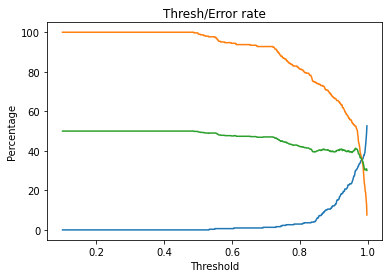

              precision    recall  f1-score   support

           0       0.51      0.21      0.30       524
           1       1.00      1.00      1.00      4429
           2       0.94      0.54      0.69       240
           3       0.97      0.93      0.95      6368
           4       0.97      1.00      0.98     83554
           5       1.00      1.00      1.00     28319
           6       0.97      0.88      0.92     25302
           7       0.75      0.86      0.80      1023
           8       0.94      0.96      0.95     13570

    accuracy                           0.97    163329
   macro avg       0.89      0.82      0.84    163329
weighted avg       0.97      0.97      0.97    163329
 
 Lowest error 0.30098684210526316
 best Thresh 0.998


/tmp/ipykernel_8469/3799661135.py:7: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(PATH_CSV)


column deleted Duration
column deleted Scr_bytes
column deleted Des_bytes
column deleted Scr_pkts
column deleted Scr_ip_bytes
column deleted Des_pkts
column deleted Des_ip_bytes
column deleted total_bytes
column deleted total_packet
column deleted paket_rate
column deleted byte_rate
column deleted Scr_packts_ratio
column deleted Des_pkts_ratio
column deleted Scr_bytes_ratio
column deleted Des_bytes_ratio
iteration  100  in Epoch  0  Loss :  tensor(0.4917)  Accuracy:  87.52068403407867
iteration  200  in Epoch  0  Loss :  tensor(0.2310)  Accuracy:  90.08642696767447
iteration  300  in Epoch  0  Loss :  tensor(0.1391)  Accuracy:  94.35856426660105
iteration  400  in Epoch  0  Loss :  tensor(0.2108)  Accuracy:  95.06166764063606
iteration  500  in Epoch  0  Loss :  tensor(0.0500)  Accuracy:  95.40553009565404
iteration  600  in Epoch  0  Loss :  tensor(0.1994)  Accuracy:  95.24436379294436
iteration  700  in Epoch  0  Loss :  tensor(0.2598)  Accuracy:  95.82382431642728
iteration  800  in

iteration  9600  in Epoch  0  Loss :  tensor(0.0226)  Accuracy:  97.27924214929413
iteration  9700  in Epoch  0  Loss :  tensor(0.0435)  Accuracy:  96.8203487835635
iteration  9800  in Epoch  0  Loss :  tensor(0.0820)  Accuracy:  97.27555131793436
iteration  9900  in Epoch  0  Loss :  tensor(0.1067)  Accuracy:  97.17712914834067
iteration  10000  in Epoch  0  Loss :  tensor(0.0186)  Accuracy:  97.19927413649924
iteration  10100  in Epoch  0  Loss :  tensor(0.1465)  Accuracy:  97.18943191953987
iteration  10200  in Epoch  0  Loss :  tensor(0.0841)  Accuracy:  96.88370805523944
iteration  10300  in Epoch  0  Loss :  tensor(0.0832)  Accuracy:  97.06701934610771
iteration  10400  in Epoch  0  Loss :  tensor(0.1144)  Accuracy:  97.15129332882232
iteration  10500  in Epoch  0  Loss :  tensor(0.0187)  Accuracy:  96.9968935502722
iteration  10600  in Epoch  0  Loss :  tensor(0.2331)  Accuracy:  97.1906621966598
iteration  10700  in Epoch  0  Loss :  tensor(0.1645)  Accuracy:  97.03687755666964

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


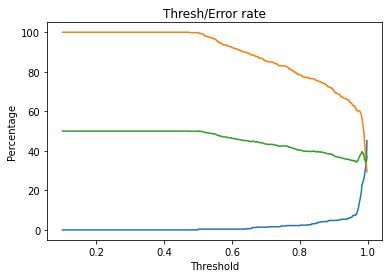

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4406
           1       0.93      0.97      0.95      6387
           2       0.97      1.00      0.98     83787
           3       1.00      1.00      1.00     28235
           4       1.00      0.85      0.92     25374
           5       0.98      0.62      0.76      1049
           6       0.90      1.00      0.95     13327

    accuracy                           0.97    162565
   macro avg       0.97      0.92      0.94    162565
weighted avg       0.97      0.97      0.97    162565
 
 Lowest error 0.342
 best Thresh 0.967
iteration  100  in Epoch  0  Loss :  tensor(0.2801)  Accuracy:  88.3860769498277
iteration  200  in Epoch  0  Loss :  tensor(0.1029)  Accuracy:  92.92845626126268
iteration  300  in Epoch  0  Loss :  tensor(0.1515)  Accuracy:  94.69065157598558
iteration  400  in Epoch  0  Loss :  tensor(0.1886)  Accuracy:  95.07571686004236
iteration  500  in Epoch  0  Loss : 

iteration  9300  in Epoch  0  Loss :  tensor(0.0326)  Accuracy:  96.85941007239734
iteration  9400  in Epoch  0  Loss :  tensor(0.0531)  Accuracy:  96.78163826625779
iteration  9500  in Epoch  0  Loss :  tensor(0.0450)  Accuracy:  97.24573993866777
iteration  9600  in Epoch  0  Loss :  tensor(0.0625)  Accuracy:  96.96626726945085
iteration  9700  in Epoch  0  Loss :  tensor(0.1146)  Accuracy:  97.09715152856376
iteration  9800  in Epoch  0  Loss :  tensor(0.0808)  Accuracy:  97.03518700009484
iteration  9900  in Epoch  0  Loss :  tensor(0.1994)  Accuracy:  97.09019632638866
iteration  10000  in Epoch  0  Loss :  tensor(0.0961)  Accuracy:  97.1230754639436
iteration  10100  in Epoch  0  Loss :  tensor(0.0401)  Accuracy:  97.03392241788119
iteration  10200  in Epoch  0  Loss :  tensor(0.0754)  Accuracy:  97.02064430463786
iteration  10300  in Epoch  0  Loss :  tensor(0.1594)  Accuracy:  96.83791217476526
iteration  10400  in Epoch  0  Loss :  tensor(0.0212)  Accuracy:  96.96437039613038


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


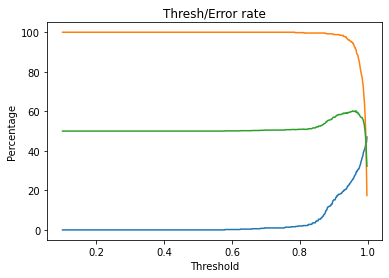

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6285
           1       0.97      1.00      0.98     83767
           2       1.00      1.00      1.00     28307
           3       1.00      0.85      0.92     25392
           4       0.87      0.78      0.82      1049
           5       0.90      1.00      0.95     13355

    accuracy                           0.97    158155
   macro avg       0.95      0.93      0.94    158155
weighted avg       0.97      0.97      0.97    158155
 
 Lowest error 0.322
 best Thresh 0.998
iteration  100  in Epoch  0  Loss :  tensor(0.4742)  Accuracy:  87.88853689293514
iteration  200  in Epoch  0  Loss :  tensor(0.4372)  Accuracy:  89.50696644419155
iteration  300  in Epoch  0  Loss :  tensor(0.0990)  Accuracy:  94.90050133792637
iteration  400  in Epoch  0  Loss :  tensor(0.1191)  Accuracy:  94.94171562144373
iteration  500  in Epoch  0  Loss :  tensor(0.0630)  Accuracy:  95.37846399901578
iterati

iteration  9400  in Epoch  0  Loss :  tensor(0.1190)  Accuracy:  96.34853750807369
iteration  9500  in Epoch  0  Loss :  tensor(0.0308)  Accuracy:  97.12914834066373
iteration  9600  in Epoch  0  Loss :  tensor(0.0834)  Accuracy:  97.03503214098976
iteration  9700  in Epoch  0  Loss :  tensor(0.1113)  Accuracy:  97.0048903515517
iteration  9800  in Epoch  0  Loss :  tensor(0.1474)  Accuracy:  97.12422723218405
iteration  9900  in Epoch  0  Loss :  tensor(0.0876)  Accuracy:  96.9796696705933
iteration  10000  in Epoch  0  Loss :  tensor(0.1206)  Accuracy:  96.93784024851598
iteration  10100  in Epoch  0  Loss :  tensor(0.1010)  Accuracy:  97.15067819026235
iteration  10200  in Epoch  0  Loss :  tensor(0.0198)  Accuracy:  96.80066434964476
iteration  10300  in Epoch  0  Loss :  tensor(0.2916)  Accuracy:  97.04548949650909
iteration  10400  in Epoch  0  Loss :  tensor(0.1152)  Accuracy:  97.17897456402055
iteration  10500  in Epoch  0  Loss :  tensor(0.0270)  Accuracy:  97.12422723218405


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


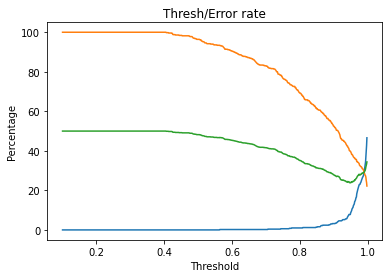

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4406
           1       0.99      0.83      0.90      6387
           2       0.97      1.00      0.98     83787
           3       1.00      1.00      1.00     28235
           4       1.00      0.85      0.92     25374
           5       0.52      0.97      0.68      1049
           6       0.90      1.00      0.95     13327

    accuracy                           0.97    162565
   macro avg       0.91      0.95      0.92    162565
weighted avg       0.97      0.97      0.97    162565
 
 Lowest error 0.23800000000000002
 best Thresh 0.949
iteration  100  in Epoch  0  Loss :  tensor(0.2996)  Accuracy:  91.4979109481672
iteration  200  in Epoch  0  Loss :  tensor(0.2842)  Accuracy:  93.05846145971297
iteration  300  in Epoch  0  Loss :  tensor(0.1946)  Accuracy:  95.11552168710931
iteration  400  in Epoch  0  Loss :  tensor(0.1304)  Accuracy:  95.84748961872404
iteration  500  in Epo

iteration  9300  in Epoch  0  Loss :  tensor(0.1721)  Accuracy:  97.43299358248396
iteration  9400  in Epoch  0  Loss :  tensor(0.0168)  Accuracy:  97.42339610086313
iteration  9500  in Epoch  0  Loss :  tensor(0.0808)  Accuracy:  97.40292147340539
iteration  9600  in Epoch  0  Loss :  tensor(0.0185)  Accuracy:  97.3786078532993
iteration  9700  in Epoch  0  Loss :  tensor(0.0214)  Accuracy:  97.49249796853306
iteration  9800  in Epoch  0  Loss :  tensor(0.1371)  Accuracy:  97.54368453717744
iteration  9900  in Epoch  0  Loss :  tensor(0.0218)  Accuracy:  97.39908248075704
iteration  10000  in Epoch  0  Loss :  tensor(0.1700)  Accuracy:  97.55072269036604
iteration  10100  in Epoch  0  Loss :  tensor(0.0253)  Accuracy:  97.41379861924231
iteration  10200  in Epoch  0  Loss :  tensor(0.1161)  Accuracy:  97.41571811556648
iteration  10300  in Epoch  0  Loss :  tensor(0.0419)  Accuracy:  97.50721410701831
iteration  10400  in Epoch  0  Loss :  tensor(0.0966)  Accuracy:  97.51041326755859


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


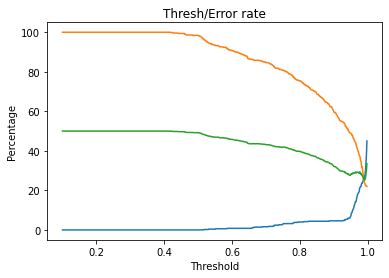

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4388
           1       0.97      1.00      0.98     83791
           2       1.00      1.00      1.00     28404
           3       0.97      0.88      0.92     25387
           4       0.99      0.99      0.99      1013
           5       0.95      0.96      0.95     13308

    accuracy                           0.98    156291
   macro avg       0.98      0.97      0.97    156291
weighted avg       0.98      0.98      0.97    156291
 
 Lowest error 0.252
 best Thresh 0.99
iteration  100  in Epoch  0  Loss :  tensor(0.4113)  Accuracy:  88.35506023025856
iteration  200  in Epoch  0  Loss :  tensor(0.1962)  Accuracy:  94.42759040885493
iteration  300  in Epoch  0  Loss :  tensor(0.2105)  Accuracy:  95.51160812886356
iteration  400  in Epoch  0  Loss :  tensor(0.2272)  Accuracy:  96.50296391261853
iteration  500  in Epoch  0  Loss :  tensor(0.1563)  Accuracy:  94.92263362993616
iteratio

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


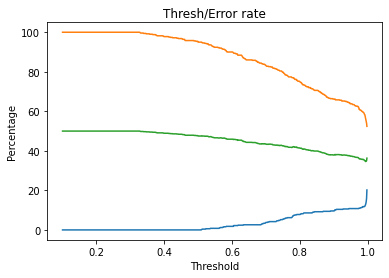

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4372
           1       0.98      0.95      0.96      6261
           2       1.00      1.00      1.00     28193
           3       0.98      0.97      0.97     25525
           4       0.76      0.89      0.82      1020
           5       0.94      0.96      0.95     13410

    accuracy                           0.98     78781
   macro avg       0.94      0.96      0.95     78781
weighted avg       0.98      0.98      0.98     78781
 
 Lowest error 0.34600000000000003
 best Thresh 0.994
iteration  100  in Epoch  0  Loss :  tensor(0.4883)  Accuracy:  85.4703653807507
iteration  200  in Epoch  0  Loss :  tensor(0.4958)  Accuracy:  86.43498842601207
iteration  300  in Epoch  0  Loss :  tensor(0.2509)  Accuracy:  93.8773231710494
iteration  400  in Epoch  0  Loss :  tensor(0.2365)  Accuracy:  92.83678071944802
iteration  500  in Epoch  0  Loss :  tensor(0.1488)  Accuracy:  94.6640566269

iteration  9300  in Epoch  0  Loss :  tensor(0.1323)  Accuracy:  96.29930109487692
iteration  9400  in Epoch  0  Loss :  tensor(0.1538)  Accuracy:  96.53226946923404
iteration  9500  in Epoch  0  Loss :  tensor(0.0252)  Accuracy:  96.54120116409756
iteration  9600  in Epoch  0  Loss :  tensor(0.1495)  Accuracy:  96.5233377743705
iteration  9700  in Epoch  0  Loss :  tensor(0.0940)  Accuracy:  96.74663014595878
iteration  9800  in Epoch  0  Loss :  tensor(0.2117)  Accuracy:  96.84115724993116
iteration  9900  in Epoch  0  Loss :  tensor(0.0613)  Accuracy:  96.92675265903999
iteration  10000  in Epoch  0  Loss :  tensor(0.0879)  Accuracy:  96.97215544126294
iteration  10100  in Epoch  0  Loss :  tensor(0.0167)  Accuracy:  96.31121002136163
iteration  10200  in Epoch  0  Loss :  tensor(0.1804)  Accuracy:  96.74588583805348
iteration  10300  in Epoch  0  Loss :  tensor(0.1894)  Accuracy:  97.1076194800265
iteration  10400  in Epoch  0  Loss :  tensor(0.0459)  Accuracy:  96.53152516132874
i

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


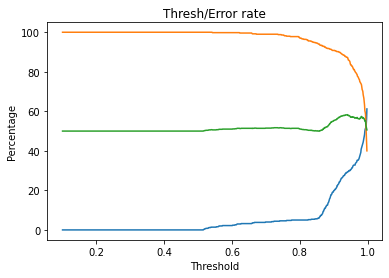

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4455
           1       0.95      0.96      0.96      6337
           2       0.97      1.00      0.99     83741
           3       0.95      0.90      0.92     25499
           4       0.82      0.78      0.80      1015
           5       0.98      0.91      0.94     13306

    accuracy                           0.97    134353
   macro avg       0.94      0.92      0.93    134353
weighted avg       0.97      0.97      0.97    134353
 
 Lowest error 0.5
 best Thresh 0.1
iteration  100  in Epoch  0  Loss :  tensor(0.3411)  Accuracy:  92.58068045071656
iteration  200  in Epoch  0  Loss :  tensor(0.0936)  Accuracy:  96.96167450680086
iteration  300  in Epoch  0  Loss :  tensor(0.1012)  Accuracy:  97.3919702439558
iteration  400  in Epoch  0  Loss :  tensor(0.0386)  Accuracy:  97.98052729460672
iteration  500  in Epoch  0  Loss :  tensor(0.0159)  Accuracy:  98.71859388104876
iteration  6

iteration  9300  in Epoch  0  Loss :  tensor(0.0058)  Accuracy:  99.52011085585093
iteration  9400  in Epoch  0  Loss :  tensor(0.0045)  Accuracy:  99.27724902454145
iteration  9500  in Epoch  0  Loss :  tensor(0.0008)  Accuracy:  99.37278926448602
iteration  9600  in Epoch  0  Loss :  tensor(0.0179)  Accuracy:  99.52302811508588
iteration  9700  in Epoch  0  Loss :  tensor(0.0004)  Accuracy:  99.56168179994894
iteration  9800  in Epoch  0  Loss :  tensor(0.0082)  Accuracy:  99.54199030011304
iteration  9900  in Epoch  0  Loss :  tensor(0.0283)  Accuracy:  99.5529300222441
iteration  10000  in Epoch  0  Loss :  tensor(0.0005)  Accuracy:  99.57116289246252
iteration  10100  in Epoch  0  Loss :  tensor(0.0535)  Accuracy:  99.36184954235496
iteration  10200  in Epoch  0  Loss :  tensor(0.0062)  Accuracy:  99.32173722787441
iteration  10300  in Epoch  0  Loss :  tensor(0.0135)  Accuracy:  99.15618276629107
iteration  10400  in Epoch  0  Loss :  tensor(0.0189)  Accuracy:  99.33486489443167


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


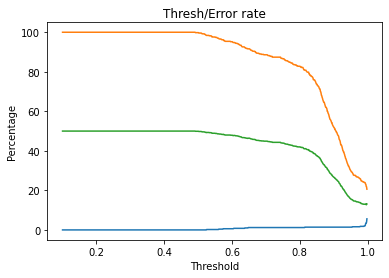

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4464
           1       0.92      0.98      0.95      6295
           2       1.00      1.00      1.00     83896
           3       1.00      1.00      1.00     28081
           4       0.86      0.79      0.82      1018
           5       1.00      1.00      1.00     13361

    accuracy                           0.99    137115
   macro avg       0.96      0.96      0.96    137115
weighted avg       0.99      0.99      0.99    137115
 
 Lowest error 0.127
 best Thresh 0.996
iteration  100  in Epoch  0  Loss :  tensor(0.3031)  Accuracy:  88.23056067940132
iteration  200  in Epoch  0  Loss :  tensor(0.1797)  Accuracy:  92.49724550305162
iteration  300  in Epoch  0  Loss :  tensor(0.3234)  Accuracy:  80.2586132191094
iteration  400  in Epoch  0  Loss :  tensor(0.0989)  Accuracy:  95.98710028844845
iteration  500  in Epoch  0  Loss :  tensor(0.0381)  Accuracy:  96.0731396313307
iteration

iteration  9300  in Epoch  0  Loss :  tensor(0.0400)  Accuracy:  97.52590465107642
iteration  9400  in Epoch  0  Loss :  tensor(0.0220)  Accuracy:  97.45100709360338
iteration  9500  in Epoch  0  Loss :  tensor(0.2555)  Accuracy:  97.49186030677049
iteration  9600  in Epoch  0  Loss :  tensor(0.0455)  Accuracy:  97.51909578221523
iteration  9700  in Epoch  0  Loss :  tensor(0.0130)  Accuracy:  97.54633125765997
iteration  9800  in Epoch  0  Loss :  tensor(0.0104)  Accuracy:  97.35630191762506
iteration  9900  in Epoch  0  Loss :  tensor(0.0832)  Accuracy:  97.43243745125469
iteration  10000  in Epoch  0  Loss :  tensor(0.0229)  Accuracy:  97.4441982247422
iteration  10100  in Epoch  0  Loss :  tensor(0.0166)  Accuracy:  97.4732906644218
iteration  10200  in Epoch  0  Loss :  tensor(0.0571)  Accuracy:  97.40520197580994
iteration  10300  in Epoch  0  Loss :  tensor(0.1345)  Accuracy:  97.44667417705536
iteration  10400  in Epoch  0  Loss :  tensor(0.0318)  Accuracy:  97.62432375552447
i

/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


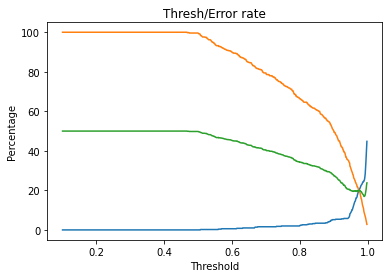

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4386
           1       0.99      0.97      0.98      6355
           2       0.97      1.00      0.98     83790
           3       1.00      1.00      1.00     28323
           4       1.00      0.85      0.92     25353
           5       0.91      1.00      0.95     13347

    accuracy                           0.97    161554
   macro avg       0.98      0.97      0.97    161554
weighted avg       0.98      0.97      0.97    161554
 
 Lowest error 0.16899999999999998
 best Thresh 0.99
iteration  100  in Epoch  0  Loss :  tensor(0.3393)  Accuracy:  85.82549399561489
iteration  200  in Epoch  0  Loss :  tensor(0.1512)  Accuracy:  95.41440650123037
iteration  300  in Epoch  0  Loss :  tensor(0.2053)  Accuracy:  95.39697333395914
iteration  400  in Epoch  0  Loss :  tensor(0.0559)  Accuracy:  96.89957825145332
iteration  500  in Epoch  0  Loss :  tensor(0.0282)  Accuracy:  96.936456105

iteration  9300  in Epoch  0  Loss :  tensor(0.0228)  Accuracy:  97.9294761333235
iteration  9400  in Epoch  0  Loss :  tensor(0.1020)  Accuracy:  97.92277106898841
iteration  9500  in Epoch  0  Loss :  tensor(0.0723)  Accuracy:  97.93349917192455
iteration  9600  in Epoch  0  Loss :  tensor(0.0237)  Accuracy:  97.87516511220925
iteration  9700  in Epoch  0  Loss :  tensor(0.0351)  Accuracy:  97.76520205711374
iteration  9800  in Epoch  0  Loss :  tensor(0.0379)  Accuracy:  97.59824595516994
iteration  9900  in Epoch  0  Loss :  tensor(0.0967)  Accuracy:  97.74240483837443
iteration  10000  in Epoch  0  Loss :  tensor(0.1159)  Accuracy:  97.83962827123327
iteration  10100  in Epoch  0  Loss :  tensor(0.1734)  Accuracy:  97.67334267572298
iteration  10200  in Epoch  0  Loss :  tensor(0.0366)  Accuracy:  97.88254068297785
iteration  10300  in Epoch  0  Loss :  tensor(0.0726)  Accuracy:  97.76386104424672
iteration  10400  in Epoch  0  Loss :  tensor(0.0404)  Accuracy:  97.94087474269315


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


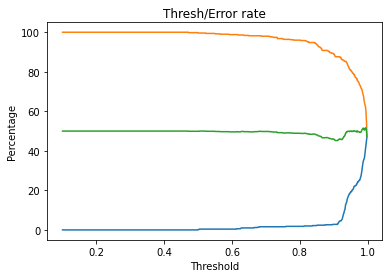

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4459
           1       0.98      0.90      0.94      6278
           2       0.97      1.00      0.98     83818
           3       1.00      1.00      1.00     28288
           4       1.00      0.91      0.95     25302
           5       0.65      0.91      0.76       996

    accuracy                           0.98    149141
   macro avg       0.93      0.95      0.94    149141
weighted avg       0.98      0.98      0.98    149141
 
 Lowest error 0.45199999999999996
 best Thresh 0.906
iteration  100  in Epoch  0  Loss :  tensor(0.4668)  Accuracy:  85.95269584473903
iteration  200  in Epoch  0  Loss :  tensor(0.3081)  Accuracy:  89.31196752068404
iteration  300  in Epoch  0  Loss :  tensor(0.1237)  Accuracy:  94.48651308707286
iteration  400  in Epoch  0  Loss :  tensor(0.1658)  Accuracy:  95.30280195614063
iteration  500  in Epoch  0  Loss :  tensor(0.0434)  Accuracy:  95.30526251

iteration  9300  in Epoch  0  Loss :  tensor(0.0497)  Accuracy:  96.9298434472365
iteration  9400  in Epoch  0  Loss :  tensor(0.1034)  Accuracy:  97.08608864146649
iteration  9500  in Epoch  0  Loss :  tensor(0.2926)  Accuracy:  97.20911635345861
iteration  9600  in Epoch  0  Loss :  tensor(0.0257)  Accuracy:  97.18635622674007
iteration  9700  in Epoch  0  Loss :  tensor(0.0819)  Accuracy:  97.09777627410574
iteration  9800  in Epoch  0  Loss :  tensor(0.1162)  Accuracy:  97.08239781010673
iteration  9900  in Epoch  0  Loss :  tensor(0.0347)  Accuracy:  96.91384984467751
iteration  10000  in Epoch  0  Loss :  tensor(0.1249)  Accuracy:  97.21342232337834
iteration  10100  in Epoch  0  Loss :  tensor(0.1073)  Accuracy:  97.03503214098976
iteration  10200  in Epoch  0  Loss :  tensor(0.0434)  Accuracy:  97.31676560145172
iteration  10300  in Epoch  0  Loss :  tensor(0.0354)  Accuracy:  97.17220803986098
iteration  10400  in Epoch  0  Loss :  tensor(0.0752)  Accuracy:  97.13776028050319


/tmp/ipykernel_8469/3448145030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_p, top_class = torch.tensor(prob).topk(1, dim = 1)


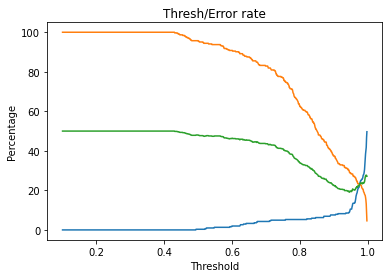

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4406
           1       0.93      0.97      0.95      6387
           2       0.97      1.00      0.98     83787
           3       1.00      1.00      1.00     28235
           4       0.98      0.88      0.93     25374
           5       0.95      0.61      0.74      1049
           6       0.96      0.97      0.96     13327

    accuracy                           0.97    162565
   macro avg       0.97      0.92      0.94    162565
weighted avg       0.97      0.97      0.97    162565
 
 Lowest error 0.1907894736842105
 best Thresh 0.947


In [27]:
create_MLP_experiment_imbalanced('../Results/MLP-IMBALANCED/class 2/')